# Assignment 1 for FIT5212, Semester 1

**Student Name:**  Siaohsuan, Jiang

**Student ID:**    33029229

# Part 1:  Text Classification

General comments and any shared processing here.

In [ ]:
!pip3 install torch
!pip3 install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 1.4 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.9.0 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0,

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torchtext.legacy import data
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize    
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.metrics import precision_recall_curve
from torchtext.legacy.data import TabularDataset
import torch.optim as optim
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
import warnings
import time
from pandas.plotting import parallel_coordinates
warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

I created a folder named `FIT5212_Ass1` in my Google Drive and uploaded the provided CSV datasets to it for processing. Please ensure to specify the correct directory while testing.

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/FIT5212_Ass1/train.csv")
test = pd.read_csv("/content/drive/MyDrive/FIT5212_Ass1/test.csv")
train.tail(10)

title  \
124990  Micro-CT Synthesis and Inner Ear Super Resolut...   
124991  Incidental Supervision: Moving beyond Supervis...   
124992  Improving a Multi-Source Neural Machine Transl...   
124993       Codes and caps from orthogonal Grassmannians   
124994  Trends Limitations and Open Challenges in Auto...   
124995  Domain Adaptation for Ear Recognition Using De...   
124996                      DeepHashing using TripletLoss   
124997  Appearance Based Deep Domain Adaptation for th...   
124998  The Importance of Automatic Syntactic Features...   
124999  Promising Accurate Prefix Boosting for sequenc...   

                                                 abstract  InformationTheory  \
124990    Existing medical image super-resolution meth...                  0   
124991    Machine Learning and Inference methods have ...                  0   
124992    In machine translation we often try to colle...                  0   
124993    In this paper we investigate linear error co...                  1   
124994    Readability assessment is the task of evalua...                  0   
124995    In this paper we have extensively investigat...                  0   
124996    Hashing is one of the most efficient techniq...                  0   
124997    This paper addresses domain adaptation for t...                  0   
124998    This paper presents a state-of-the-art syste...                  0   
124999    In this paper we present promising accurate ...                  0   

        ComputationalLinguistics  ComputerVision  
124990                         0               1  
124991                         1               0  
124992                         1               0  
124993                         0               0  
124994                         1               0  
124995                         0               1  
124996                         0               1  
124997                         0               1  
124998                         1               0  
124999                         1               0

## Part 1A: Statistical Method

For this assignment, we need to build 48 models - half of which are statistical models, and the other half are RNN models. Since either 24 statistical or 24 RNN models share the same structure but have different combinations of parameters, for Statistical and RNN, I created `class` objects respectively that wraps most of the methods and functions. This makes the code more organized, avoids repeating lengthy code, and allows all models to be handled as a class.

In the `__init__` function, we initialize values from the input parameters to build an object. Once we have all the parameters, we use the `dataPrepare` function to split the original data into the necessary format for further analysis.

During the `fit` function, we perform both preprocessing and fitting. Firstly, we initialize a vectorizer at the beginning of the function, based on our chosen preprocessing method. Subsequently, we train and vectorize (or transform) our input text data using the vectorizer's predefined methods. Towards the end of the fit function, we use the transformed data to fit a statistical model and save it for future testing and prediction.<br>
<br>
In text classification, I chose to use random forest rather than SVM and logistic regression. One reason is random forest has built-in feature selection. It identifies the most relevant and important features for classification. Another reason why I chose random forest for text classification is its ability to handle high-dimensional data. As we know, text data often has a large number of features, and compared to SVM and logistic regression, these methods can struggle with high-dimensional data.


In [ ]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl=WordNetLemmatizer()
    def __call__(self,doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]


class StatisticalClassifier:
    def __init__(self, data, task="InformationTheory", input="title", preprocessing="lowercase", dataSize="1000"):
        self.data = data
        self.task = task ## [InformationTheory, ComputerVision, ComputationalLinguistics]
        self.input = input ## [title, abstract]
        self.preprocessing = preprocessing ## [max_df, lowercase]
        self.dataSize = dataSize ## [1000, all]
        self.train_data, self.train_target, self.val_data, self.val_target = self.dataPrepare()

    def dataPrepare(self):
        """
            This function is used to split the original data into train_data, train_target, val_data, and val_target based on the given dataSize.
            For both cases, the validation/development set is the last 10% of the training data
        """
        try:
            if self.dataSize == "1000": # 1000 train data condition
                ## data and target of train data
                train_data = self.data.head(int(1000*0.9)) # first 90% of the data
                train_target = np.asarray(self.data[self.task].head(int(1000*0.9)).tolist()) # first 90% of the data
                ## data and target of validation(tail 10%)
                val_data = self.data.head(1000).tail(int(1000*0.1)) # the last 100 data of the first 1000 data
                val_target = np.asarray(self.data.head(1000)[self.task].tail(int(1000*0.1)).tolist()) # the last 100 data of the first 1000 data
                return train_data, train_target, val_data, val_target

            elif self.dataSize == "all": # all train data condition
                ## data and target of train data
                train_data = self.data.head(int(len(self.data)*0.9)) # first 90% of the data
                train_target = np.asarray(self.data[self.task].head(int(len(self.data)*0.9)).tolist()) # first 90% of the data
                ## data and target of validation(tail 10%)
                val_data = self.data.tail(int(len(self.data)*0.1)) # last 10% of the data
                val_target = np.asarray(self.data[self.task].tail(int(len(self.data)*0.1)).tolist()) # the last 10% of the data
                return train_data, train_target, val_data, val_target

        except Exception as e:
            print(e)
            print("Invalid input parameters.")
            return None, None, None, None

    def fit(self):
        """
            Preprocessing and fitting are performed. 
            A vectorizer is initialized based on the preprocessing method, data is transformed, 
            and a statistical model is fitted and saved for future prediction.
        """
        try:
            if self.preprocessing == "maxDF": # When building the vocabulary ignore terms that have a document frequency higher than 50%
                self.vectorizer = TfidfVectorizer(analyzer='word',input='content',
                                lowercase=True,
                                min_df=0.005,
                                max_df=0.5,
                                ngram_range=(1, 1),
                                tokenizer=LemmaTokenizer())
            elif self.preprocessing == "lowercase": # When building the vocabulary turn all letters into lowercase
                self.vectorizer = TfidfVectorizer(analyzer='word',input='content',
                                lowercase=True,
                                min_df=0.005,
                                ngram_range=(1, 1),
                                tokenizer=LemmaTokenizer())
            else:
                print("Invalid preprocessing input.")
                return self

            transformed_train_data = self.vectorizer.fit_transform(self.train_data[self.input].tolist()) # vectorize input text data
            print("get_feature_names: ", len(self.vectorizer.get_feature_names_out()))

            # CalibratedClassifierCV(RandomForestClassifier(), cv=3).fit(transformed_train_data, self.train_target)
            self.model = RandomForestClassifier().fit(transformed_train_data, self.train_target) # fitting model
            # CalibratedClassifierCV(self.model, cv=)
            
            return self



        
        except Exception as e:
            print(e)
            print("Invalid input parameters(fit).")
            return None

    def predict(self, test_data=None):
        """
            return predictions
        """
        try:
            ## use validation set as test data if input is none
            if type(test_data) == type(None): # if input data is None
              test_data = self.val_data
              self.y_test = self.val_data.target
            else: 
              test_data = test_data
              self.y_test = test_data[self.task]

            transformed_test_data = self.vectorizer.transform(test_data[self.input].tolist()) # transform(vectorize) original test data for prediction
            self.y_predict = self.model.predict(transformed_test_data)
            self.y_predict_proba = self.model.predict_proba(transformed_test_data)
            return self.y_predict, self.y_predict_proba
        except Exception as e:
            print(e)
            print("Invalid input. (predict).")
            return None




Initialize 24 Statistical methods. With combination of<br>

*   Task: [ InformationTheory(Info), ComputerVision(Vis), ComputationalLinguistics(Lin) ]
*   Input: [ title(Title), abstract(Abs) ]
*   Preprocessing: [ maxDF(MaxDF), lowercase(Low) ] 
*   DataSize: [ 1000, all ]

For preprocessing, I have opted to use maxDF with a threshold of 0.5 to eliminate tokens that appear in more than half of the documents. For instance, if there are 10 documents, and token A appears in 6 of them, then token A will be eliminated. Additionally, I have chosen to use lowercase as another preprocessing method because, in most cases, capitalized tokens have the same meaning as their lowercase counterparts. Capitalization is often used only because the token is the first word of the sentence.
<br><br>
For the names of the objects, I use the prefix "Stat" to represent statistical models, followed by an abbreviation of each parameter name separated by underscores. For example, "Stat_Info_Title_MaxDF_1000" represents a statistical model for the InformationTheory task, using 1000 titles as input and MaxDF as the preprocessing method.



In [ ]:
## Combination of InformationTheory(Info)
Stat_Info_Title_MaxDF_1000 = StatisticalClassifier(train, "InformationTheory", "title", "maxDF", "1000")
Stat_Info_Title_MaxDF_all   = StatisticalClassifier(train, "InformationTheory", "title", "maxDF", "all")
Stat_Info_Title_Low_1000 = StatisticalClassifier(train, "InformationTheory", "title", "lowercase", "1000")
Stat_Info_Title_Low_all   = StatisticalClassifier(train, "InformationTheory", "title", "lowercase", "all")
Stat_Info_Abs_MaxDF_1000 = StatisticalClassifier(train, "InformationTheory", "abstract", "maxDF", "1000")
Stat_Info_Abs_MaxDF_all   = StatisticalClassifier(train, "InformationTheory", "abstract", "maxDF", "all")
Stat_Info_Abs_Low_1000 = StatisticalClassifier(train, "InformationTheory", "abstract", "lowercase", "1000")
Stat_Info_Abs_Low_all   = StatisticalClassifier(train, "InformationTheory", "abstract", "lowercase", "all")
## Combination of ComputerVision(Vis)
Stat_Vis_Title_MaxDF_1000 = StatisticalClassifier(train, "ComputerVision", "title", "maxDF", "1000")
Stat_Vis_Title_MaxDF_all   = StatisticalClassifier(train, "ComputerVision", "title", "maxDF", "all")
Stat_Vis_Title_Low_1000 = StatisticalClassifier(train, "ComputerVision", "title", "lowercase", "1000")
Stat_Vis_Title_Low_all   = StatisticalClassifier(train, "ComputerVision", "title", "lowercase", "all")
Stat_Vis_Abs_MaxDF_1000 = StatisticalClassifier(train, "ComputerVision", "abstract", "maxDF", "1000")
Stat_Vis_Abs_MaxDF_all   = StatisticalClassifier(train, "ComputerVision", "abstract", "maxDF", "all")
Stat_Vis_Abs_Low_1000 = StatisticalClassifier(train, "ComputerVision", "abstract", "lowercase", "1000")
Stat_Vis_Abs_Low_all   = StatisticalClassifier(train, "ComputerVision", "abstract", "lowercase", "all")
## Combination of ComputationalLinguistics(Lin)
Stat_Lin_Title_MaxDF_1000 = StatisticalClassifier(train, "ComputationalLinguistics", "title", "maxDF", "1000")
Stat_Lin_Title_MaxDF_all   = StatisticalClassifier(train, "ComputationalLinguistics", "title", "maxDF", "all")
Stat_Lin_Title_Low_1000 = StatisticalClassifier(train, "ComputationalLinguistics", "title", "lowercase", "1000")
Stat_Lin_Title_Low_all   = StatisticalClassifier(train, "ComputationalLinguistics", "title", "lowercase", "all")
Stat_Lin_Abs_MaxDF_1000 = StatisticalClassifier(train, "ComputationalLinguistics", "abstract", "maxDF", "1000")
Stat_Lin_Abs_MaxDF_all   = StatisticalClassifier(train, "ComputationalLinguistics", "abstract", "maxDF", "all")
Stat_Lin_Abs_Low_1000 = StatisticalClassifier(train, "ComputationalLinguistics", "abstract", "lowercase", "1000")
Stat_Lin_Abs_Low_all   = StatisticalClassifier(train, "ComputationalLinguistics", "abstract", "lowercase", "all")

print("All Statistical objects are created!!")


All Statistical objects are created!!


## Part 1B: RNN Method

Similar to the statistical model, we are aware that some preprocessing steps can be time-consuming when executed repeatedly. Therefore, in this part, I have decided to pre-process the data in advance so that the RNN object can directly read the preprocessed data and save time.
<br><br>
In the RNN model part, I chose to use `lowercase` and `stemming` as data preprocessing methods. Therefore, there are four kinds of combinations. 

*   lowercase, 1000 data
*   lowercase, all data
*   stemming, 1000 data
*   stemming, all data

I used loops to process and extract four types of data, and for each type, I  separatly process training, validation, and testing datasets. I wrote these stemmed and lowercase datasets out, and will use `TabularDataset` to import.

In [ ]:
ps = PorterStemmer() # stemmer
for n in ["1000", "all"]:
    for preprocessing in ["lowercase", "stemming"]:
        ## data amount ["1000", "all"]
        if n == "1000": # 1000 train data condition
            train_data_export = train.head(int(1000*0.9))
            val_data_export = train.head(1000).tail(int(1000*0.1))
            test_data_export = test
        elif n == "all": # all train data condition
            train_data_export = train.head(int(len(train)*0.9))
            val_data_export = train.tail(int(len(train)*0.1))
            test_data_export = test

        ## data preprocessing ["lowercase", "stemming"][, , ]
        if preprocessing == "lowercase":
            train_data_export[["title", "abstract"]] = train_data_export[["title", "abstract"]].apply(lambda x: x.astype(str).str.lower())
            val_data_export[["title", "abstract"]] = val_data_export[["title", "abstract"]].apply(lambda x: x.astype(str).str.lower())
            test_data_export[["title", "abstract"]] = test_data_export[["title", "abstract"]].apply(lambda x: x.astype(str).str.lower())
        elif preprocessing == "stemming":
            for input in ["title", "abstract"]:
                train_data_export[input] = train_data_export.apply(lambda row: nltk.word_tokenize(row[input]), axis=1).apply(lambda x: [ps.stem(y) for y in x]) ## tokenize and then stem
                train_data_export[input] = train_data_export[input].apply(lambda row: ' '.join(row)) ## turn ["a", "b"] to "a b"     
                val_data_export[input] = val_data_export.apply(lambda row: nltk.word_tokenize(row[input]), axis=1).apply(lambda x: [ps.stem(y) for y in x]) ## tokenize and then stem
                val_data_export[input] = val_data_export[input].apply(lambda row: ' '.join(row)) ## turn ["a", "b"] to "a b"     
                test_data_export[input] = test_data_export.apply(lambda row: nltk.word_tokenize(row[input]), axis=1).apply(lambda x: [ps.stem(y) for y in x]) ## tokenize and then stem
                test_data_export[input] = test_data_export[input].apply(lambda row: ' '.join(row)) ## turn ["a", "b"] to "a b"     
        print(n, preprocessing, "finish.")

        # export csv
        fileName = f"RNN_{preprocessing}_{n}"
        train_data_export.to_csv(f'/content/drive/MyDrive/FIT5212_Ass1/{fileName}_train.csv', index=False)
        val_data_export.to_csv(f'/content/drive/MyDrive/FIT5212_Ass1/{fileName}_val.csv', index=False)
        test_data_export.to_csv(f'/content/drive/MyDrive/FIT5212_Ass1/{fileName}_test.csv', index=False)

1000 lowercase finish.
1000 stemming finish.
all lowercase finish.
all stemming finish.


Set seed and device settings.

In [ ]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Refer to tutorial materials, this RNN class will be used to create model structure of RNN.
It is a PyTorch implementation of a basic RNN model for text classification. The RNN class inherits from the PyTorch nn.Module class, which is a base class for all neural network modules in PyTorch. The class has four input parameters
in the `__init__` function, the embedding layer, the RNN layer, and the fully connected layer are defined and initialized.

*    input_dim: The size of the input vector.
*    embedding_dim: The dimension of the embedding layer that converts the input data into dense vectors.
*    hidden_dim: The dimension of the hidden layer of the RNN model.
*    output_dim: The dimension of the output layer of the model.

In the forward function, the input text data is passed through the embedding layer to convert the text into dense vectors. Then, the output and the hidden states are calculated by the RNN layer, and the last hidden state is passed through the fully connected layer to generate the output prediction.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

Due to the same reasons as the statistical model, I wrapped most of the functions for building an RNN model into a class. This approach enables us to easily generate as many models as we want with a single line of code.

In the `__init__` function, we initialize values from the input parameters to build an object. Once all parameters are obtained, the `dataPrepare` function is called to import the necessary train, validation, and test data based on the given preprocessing method and dataSize.

After reading csv files, we can start to build the model and then make predictions. The whole process is in the `fit_predict` function. There are two parameters, MAX_VOCAB_SIZE and N_EPOCHS, can be set for tuning. Refer to the teaching materials, I set MAX_VOCAB_SIZE to 5400, but for N_EPOCHS, I set to 100 as a tradeoff between training time and training performance. 

After reading the csv files, we can begin building the model and making predictions using the fit_predict function. This function has two parameters, namely MAX_VOCAB_SIZE and N_EPOCHS, that can be adjusted for optimization. According to the teaching materials, I set MAX_VOCAB_SIZE to 5400. However, I set N_EPOCHS to 100 as it strikes a balance between training time and performance for me. For the batch size, I set it to 64, and I didn't observe much difference on the accuracy when I set it to other numbers in this case.

During training, `train_epochs` is about the iteration of epochs. For each epoch, we used `train_function` for training set and `evaluation` for validation set. Two functions are similar, both of them used binary cross entropy as criterion of loss and called `binary_accuracy` to get the accuracy information. The main difference between these two functions is `train_function` contains the backprobagation and optimizer updating steps while `evaluation` just calculating the results and didn't have optimization steps.

During training, `train_epochs` function is doing iteration. For each epoch, we utilize the `train_function` for the training set and `evaluation` for the validation set. Both functions use binary cross entropy as a criterion to calculate the loss and call `binary_accuracy` to obtain accuracy information. The primary difference between these two functions is that `train_function` involves backpropagation and optimizer updating steps, whereas `evaluation` solely calculates the results and does not include optimization steps.

In [ ]:
class RNNClassifier:
    def __init__(self, input_data, task="InformationTheory", input="title", preprocessing="stemming", dataSize="1000"):
        self.data = input_data
        self.task = task ## [InformationTheory, ComputerVision, ComputationalLinguistics]
        self.input = input ## [title, abstract]
        self.preprocessing = preprocessing ## [stemming, lowercase]
        self.dataSize = dataSize ## [1000, all]
        self.TEXT = data.Field(sequential=True, tokenize = 'spacy', lower=True)
        self.LABEL = data.LabelField(dtype = torch.float, use_vocab=False, preprocessing=str)
        # self.ps = PorterStemmer() # stemmer
        self.train, self.val, self.test = self.dataPrepare()
        self.epoch_info = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
        self.y_predict_proba = []

  

    def dataPrepare(self):
        """
             import the necessary train, validation, and test data based on the given preprocessing method and dataSize.
        """
        try:
            ## define fields
            self.tv_datafields = []
            for column in self.data.columns:
                if column == self.task: # pass Label in task column("InformationTheory" or "ComputerVision" or "ComputationalLinguistics")
                    self.tv_datafields.append((column, self.LABEL)) 
                elif column == self.input: # pass TEXT in input column("title" or "abstract")
                    self.tv_datafields.append((column, self.TEXT)) 
                else: # we won't be needing the source and notes, so we pass in None as the field
                    self.tv_datafields.append((column, None))

            ## Use TabularDataset class to read processed data
            filPrefix = f"RNN_{self.preprocessing}_{self.dataSize}"
            train_data, val_data, test_data= TabularDataset.splits(
                                      path='/content/drive/MyDrive/FIT5212_Ass1',  
                                      train=f'{filPrefix}_train.csv', validation=f'{filPrefix}_val.csv', test=f'{filPrefix}_test.csv',
                                      format='csv',skip_header=True, fields=self.tv_datafields)
            
            return train_data, val_data, test_data

        except Exception as e:
            print(e)
            print("Invalid input parameters.")
            return None, None

    def binary_accuracy(self, preds, y):
        """
            Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
        """

        #round predictions to the closest integer
        rounded_preds = torch.round(torch.sigmoid(preds))
        correct = (rounded_preds == y).float() #convert into float for division 
        acc = correct.sum() / len(correct)
        return acc

    def train_function(self, model, iterator, optimizer, criterion):
        """
            return two training info:
                1. Mean loss( criterion: binary cross entropy ) across all batches
                2. Mean accuracy across all batches
        """
      
        epoch_loss = 0
        epoch_acc = 0
        
        model.train()
        
        for batch in iterator:
            optimizer.zero_grad()
            predictions = model(batch.title).squeeze(1) if self.input == "title" else model(batch.abstract).squeeze(1)
            if self.task == "InformationTheory":
                loss = criterion(predictions, batch.InformationTheory) # binary cross entropy loss
                acc = self.binary_accuracy(predictions, batch.InformationTheory) # Accuracy per batch
            elif self.task == "ComputerVision":
                loss = criterion(predictions, batch.ComputerVision) # binary cross entropy loss
                acc = self.binary_accuracy(predictions, batch.ComputerVision) # Accuracy per batch
            elif self.task == "ComputationalLinguistics":
                loss = criterion(predictions, batch.ComputationalLinguistics) # binary cross entropy loss
                acc = self.binary_accuracy(predictions, batch.ComputationalLinguistics) # Accuracy per batch
            
            loss.backward() #  backpropagation, calculates the gradients of the loss with respect to each of the model's parameters.
            
            optimizer.step() # updates the model parameters based on the gradients computed during the backward pass.
            
            ## sum
            epoch_loss += loss.item() 
            epoch_acc += acc.item()

            
        return epoch_loss / len(iterator), epoch_acc / len(iterator)# mean

    def evaluate(self, model, iterator, criterion):
        """
            return two training info:
                1. Mean loss( criterion: binary cross entropy ) across all batches
                2. Mean accuracy across all batches
        """
      
        epoch_loss = 0
        epoch_acc = 0
        
        model.eval()
        
        with torch.no_grad():
        
            for batch in iterator:

                predictions = model(batch.title).squeeze(1) if self.input == "title" else model(batch.abstract).squeeze(1) 
                if self.task == "InformationTheory":
                    loss = criterion(predictions, batch.InformationTheory) # binary cross entropy loss
                    acc = self.binary_accuracy(predictions, batch.InformationTheory) # Accuracy per batch
                elif self.task == "ComputerVision":
                    loss = criterion(predictions, batch.ComputerVision) # binary cross entropy loss
                    acc = self.binary_accuracy(predictions, batch.ComputerVision) # Accuracy per batch
                elif self.task == "ComputationalLinguistics":
                    loss = criterion(predictions, batch.ComputationalLinguistics) # binary cross entropy loss
                    acc = self.binary_accuracy(predictions, batch.ComputationalLinguistics) # Accuracy per batch
                
                ## sum
                epoch_loss += loss.item()
                epoch_acc += acc.item()

        return epoch_loss / len(iterator), epoch_acc / len(iterator) # mean

    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    def train_epochs(self, model, train_iterator, valid_iterator, optimizer, criterion, N_EPOCHS=100):
        """
            Use a loop to train models, and update the best model if it has a lower loss. 
            Save epoch info(loss/acc of train and val) for visualization
        """
        best_valid_loss = float('inf')
        
        for epoch in range(N_EPOCHS): # for each epochs
            start_time = time.time()
            train_loss, train_acc = self.train_function(model, train_iterator, optimizer, criterion) # train info
            valid_loss, valid_acc = self.evaluate(model, valid_iterator, criterion) # validation info
            end_time = time.time()
            epoch_mins, epoch_secs = self.epoch_time(start_time, end_time) # get training time for a given epoch
            if valid_loss < best_valid_loss: # update best model if the model has a smaller loss
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), 'RNN_model.pt')

            ## save epoch info for the visualization
            self.epoch_info["train_loss"].append(train_loss)
            self.epoch_info["train_acc"].append(train_acc*100)
            self.epoch_info["val_loss"].append(valid_loss)
            self.epoch_info["val_acc"].append(valid_acc*100)

            
            print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    def fit_predict(self, MAX_VOCAB_SIZE=5400, N_EPOCHS=100):
        """
            return predict_target and test target
        """
        try:
            # self.MAX_VOCAB_SIZE = MAX_VOCAB_SIZE            
            self.TEXT.build_vocab(self.train, max_size = MAX_VOCAB_SIZE)
            print(f"Unique tokens in TEXT vocabulary: {len(self.TEXT.vocab)}")
            # print(self.TEXT.vocab.freqs.most_common(20)) ## view the most common words in the vocabulary and their frequencies.

            ## Creating the iterators. 
            BATCH_SIZE = 64
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # PyTorch handles this using torch.device, pass this device to the iterator.
            train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits( ##  return a batch of examples
                (self.train, self.val, self.test), 
                batch_size = BATCH_SIZE,
                device = device,
                sort_key = lambda x: len(x.title) if self.input == "title" else len(x.abstract),
                sort_within_batch = False)

            ## model parameters(refer to the materials)
            INPUT_DIM = len(self.TEXT.vocab)
            EMBEDDING_DIM = 100
            HIDDEN_DIM = 256
            OUTPUT_DIM = 1
            model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

            ## optimizer and criterion
            optimizer = optim.SGD(model.parameters(), lr=1e-3) # Use SGD algorithm to update the parameters of the module
            criterion = nn.BCEWithLogitsLoss() # Calculate the loss using binary cross entropy
            model = model.to(device) # Using '.to' to place the model and the criterion on the GPU
            criterion = criterion.to(device)
            
            ## Train the model
            self.train_epochs(model, train_iterator, valid_iterator, optimizer, criterion, N_EPOCHS=N_EPOCHS)

            ## load model
            model.load_state_dict(torch.load('RNN_model.pt'))
            y_predict = []
            y_test = []

            model.eval()
            # epoch_y_pred_proba = []
            with torch.no_grad():
                for batch in test_iterator:
                    predictions = model(batch.title).squeeze(1) if self.input == "title" else model(batch.abstract).squeeze(1)
                    ## y_pred_proba for precision recall curve
                    y_pred_proba = torch.sigmoid(predictions)
                    # print(y_pred_proba)
                    self.y_predict_proba += y_pred_proba.tolist()
                    # self.y_predict_proba.append(epoch_y_pred_proba)
                    

                    rounded_preds = torch.round(torch.sigmoid(predictions))
                    y_predict += rounded_preds.tolist()
                    if self.task == "InformationTheory":
                      y_test += batch.InformationTheory.tolist()
                    elif self.task == "ComputerVision":
                      y_test += batch.ComputerVision.tolist()
                    elif self.task == "ComputationalLinguistics":
                      y_test += batch.ComputationalLinguistics.tolist()
                    # acc = binary_accuracy(predictions, batch.label)
            self.y_predict, self.y_test = y_predict, y_test
            return y_predict, y_test

        except Exception as e:
            print(e)
            print("Invalid input parameters(predict).")
            return None


Initialize 24 RNN methods. With combination of<br>

*   Task: [ InformationTheory(Info), ComputerVision(Vis), ComputationalLinguistics(Lin) ]
*   Input: [ title(Title), abstract(Abs) ]
*   Preprocessing: [ stemming(Stem), lowercase(Low) ] 
*   DataSize: [ 1000, all ]

For the names of the objects, I use the prefix "RNN" to represent statistical models, followed by an abbreviation of each parameter name separated by underscores. For example, "RNN_Info_Title_Stem_1000" represents a statistical model for the InformationTheory task, using 1000 titles as input and stemming as the preprocessing method.

In [ ]:
## Combination of InformationTheory(Info)
RNN_Info_Title_Stem_1000 = RNNClassifier(train, "InformationTheory", "title", "stemming", "1000")
RNN_Info_Title_Stem_all   = RNNClassifier(train, "InformationTheory", "title", "stemming", "all")
RNN_Info_Title_Low_1000 = RNNClassifier(train, "InformationTheory", "title", "lowercase", "1000")
RNN_Info_Title_Low_all   = RNNClassifier(train, "InformationTheory", "title", "lowercase", "all")
RNN_Info_Abs_Stem_1000 = RNNClassifier(train, "InformationTheory", "abstract", "stemming", "1000")
RNN_Info_Abs_Stem_all   = RNNClassifier(train, "InformationTheory", "abstract", "stemming", "all")
RNN_Info_Abs_Low_1000 = RNNClassifier(train, "InformationTheory", "abstract", "lowercase", "1000")
RNN_Info_Abs_Low_all   = RNNClassifier(train, "InformationTheory", "abstract", "lowercase", "all")
## Combination of ComputerVision(Vis)
RNN_Vis_Title_Stem_1000 = RNNClassifier(train, "ComputerVision", "title", "stemming", "1000")
RNN_Vis_Title_Stem_all   = RNNClassifier(train, "ComputerVision", "title", "stemming", "all")
RNN_Vis_Title_Low_1000 = RNNClassifier(train, "ComputerVision", "title", "lowercase", "1000")
RNN_Vis_Title_Low_all   = RNNClassifier(train, "ComputerVision", "title", "lowercase", "all")
RNN_Vis_Abs_Stem_1000 = RNNClassifier(train, "ComputerVision", "abstract", "stemming", "1000")
RNN_Vis_Abs_Stem_all   = RNNClassifier(train, "ComputerVision", "abstract", "stemming", "all")
RNN_Vis_Abs_Low_1000 = RNNClassifier(train, "ComputerVision", "abstract", "lowercase", "1000")
RNN_Vis_Abs_Low_all   = RNNClassifier(train, "ComputerVision", "abstract", "lowercase", "all")
## Combination of ComputationalLinguistics(Lin)
RNN_Lin_Title_Stem_1000 = RNNClassifier(train, "ComputationalLinguistics", "title", "stemming", "1000")
RNN_Lin_Title_Stem_all   = RNNClassifier(train, "ComputationalLinguistics", "title", "stemming", "all")
RNN_Lin_Title_Low_1000 = RNNClassifier(train, "ComputationalLinguistics", "title", "lowercase", "1000")
RNN_Lin_Title_Low_all   = RNNClassifier(train, "ComputationalLinguistics", "title", "lowercase", "all")
RNN_Lin_Abs_Stem_1000 = RNNClassifier(train, "ComputationalLinguistics", "abstract", "stemming", "1000")
RNN_Lin_Abs_Stem_all   = RNNClassifier(train, "ComputationalLinguistics", "abstract", "stemming", "all")
RNN_Lin_Abs_Low_1000 = RNNClassifier(train, "ComputationalLinguistics", "abstract", "lowercase", "1000")
RNN_Lin_Abs_Low_all   = RNNClassifier(train, "ComputationalLinguistics", "abstract", "lowercase", "all")

print("All RNN objects created!!")

All RNN objects created!!


## Part 1C:  Results for Methods
Define a `result` function for calculating confusion matrix, F1, precision, recall score, accuracy, matthews_corrcoef.

In [ ]:
def result(y_predict, y_test):
    """
        Input: predict y and real y
    """
    y_predict = np.asarray(y_predict)
    y_test = np.asarray(y_test)
    print(confusion_matrix(y_test,y_predict))
    recall=recall_score(y_test,y_predict,average='macro')
    precision=precision_score(y_test,y_predict,average='macro')
    f1score=f1_score(y_test,y_predict,average='macro')
    accuracy=accuracy_score(y_test,y_predict)
    matthews = matthews_corrcoef(y_test,y_predict) 
    print('Accuracy: '+ str(accuracy))
    print('Macro Precision: '+ str(precision))
    print('Macro Recall: '+ str(recall))
    print('Macro F1 score:'+ str(f1score))
    print('MCC:'+ str(matthews))

Define a `parallel` function for vizalization of 5 scores and comparison among different models.

In [ ]:
def parallel(models, y_test):
    """
        Input: predict y and real y
    """
    df = pd.DataFrame()
    Names = []
    Accuracy = []
    Precision = []
    Recall = []
    F1 = []
    MCC = []
    for model in models:
        Names.append(f"{model.task}_{model.input}_{model.preprocessing}_{model.dataSize}")
        Recall.append(recall_score(y_test,model.y_predict,average='macro'))
        Precision.append(precision_score(y_test,model.y_predict,average='macro'))
        F1.append(f1_score(y_test,model.y_predict,average='macro'))
        Accuracy.append(accuracy_score(y_test,model.y_predict))
        MCC.append(matthews_corrcoef(y_test,model.y_predict))

    df['Names'], df['Accuracy'], df['Macro Precision'], df['Macro Recall'], df['Macro F1 score'], df['MCC'] = Names, Accuracy, Precision, Recall, F1, MCC

    parallel_coordinates(df, "Names")
    plt.legend()
    plt.show()


### Results of Statistical models

**-------------------- All Statistical models --------------------**

Combination of InformationTheory(Info)
> Stat_Info_Title_MaxDF_100 \\
> Stat_Info_Title_MaxDF_all \\
> Stat_Info_Title_Low_100 \\
> Stat_Info_Title_Low_all \\
> Stat_Info_Abs_MaxDF_100 \\
> Stat_Info_Abs_MaxDF_all \\
> Stat_Info_Abs_Low_100 \\
> Stat_Info_Abs_Low_all \\

Combination of ComputerVision(Vis)
> Stat_Vis_Title_MaxDF_100 \\
> Stat_Vis_Title_MaxDF_all \\
> Stat_Vis_Title_Low_100 \\
> Stat_Vis_Title_Low_all \\
> Stat_Vis_Abs_MaxDF_100 \\
> Stat_Vis_Abs_MaxDF_all \\
> Stat_Vis_Abs_Low_100 \\
> Stat_Vis_Abs_Low_all \\

Combination of ComputationalLinguistics(Lin)
> Stat_Lin_Title_MaxDF_100 \\
> Stat_Lin_Title_MaxDF_all \\
> Stat_Lin_Title_Low_100 \\
> Stat_Lin_Title_Low_all \\
> Stat_Lin_Abs_MaxDF_100 \\
> Stat_Lin_Abs_MaxDF_all \\
> Stat_Lin_Abs_Low_1000 \\
> Stat_Lin_Abs_Low_all  \\



#### InformationTheory(Statistical)

In [ ]:
## Statistical Prediction Results of "InformationTheory"
models = [Stat_Info_Title_MaxDF_1000, Stat_Info_Title_MaxDF_all, Stat_Info_Title_Low_1000, Stat_Info_Title_Low_all , 
          Stat_Info_Abs_MaxDF_1000, Stat_Info_Abs_MaxDF_all, Stat_Info_Abs_Low_1000, Stat_Info_Abs_Low_all]
print("--------------------- InformationTheory ---------------------")
for model in models:
    print(f"--- {model.task}_{model.input}_{model.preprocessing}_{model.dataSize} ---")
    result(model.fit().predict(test_data=test)[0], test["InformationTheory"])
    print("\n")


--------------------- InformationTheory ---------------------
--- InformationTheory_title_maxDF_1000 ---
get_feature_names:  282
[[9317  270]
 [3478 5001]]
Accuracy: 0.7925384700542455
Macro Precision: 0.8384756958322018
Macro Recall: 0.7808234907678391
Macro F1 score:0.779981095198252
MCC:0.616609848911521


--- InformationTheory_title_maxDF_all ---
get_feature_names:  269
[[9222  365]
 [2107 6372]]
Accuracy: 0.8631683825971438
Macro Precision: 0.8799193532506049
Macro Recall: 0.8567156626831802
Macro F1 score:0.8596761991634858
MCC:0.7362694720303287


--- InformationTheory_title_lowercase_1000 ---
get_feature_names:  282
[[9307  280]
 [3515 4964]]
Accuracy: 0.7899368980405181
Macro Precision: 0.8362337222886722
Macro Recall: 0.7781200901144623
Macro F1 score:0.7770526851233152
MCC:0.611599061943187


--- InformationTheory_title_lowercase_all ---
get_feature_names:  269
[[9225  362]
 [2118 6361]]
Accuracy: 0.8627255618288497
Macro Precision: 0.8797159506009187
Macro Recall: 0.8562234

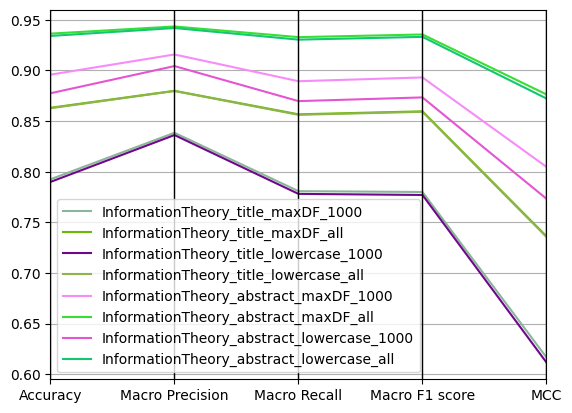

In [ ]:
parallel(models, test["InformationTheory"])

#### ComputerVision(Statistical)

In [ ]:
## Statistical Prediction Results of "ComputerVision"
models = [Stat_Vis_Title_MaxDF_1000, Stat_Vis_Title_MaxDF_all, Stat_Vis_Title_Low_1000, Stat_Vis_Title_Low_all, 
          Stat_Vis_Abs_MaxDF_1000, Stat_Vis_Abs_MaxDF_all, Stat_Vis_Abs_Low_1000, Stat_Vis_Abs_Low_all]
print("--------------------- ComputerVision ---------------------")
for model in models:
    print(f"--- {model.task}_{model.input}_{model.preprocessing}_{model.dataSize} ---")
    result(model.fit().predict(test_data=test)[0], test["ComputerVision"])
    print("\n")

--------------------- ComputerVision ---------------------
--- ComputerVision_title_maxDF_1000 ---
get_feature_names:  282
[[9872 1975]
 [1346 4873]]
Accuracy: 0.8161740285619395
Macro Precision: 0.7958044444800829
Macro Recall: 0.8084288091725538
Macro F1 score:0.80093196413004
MCC:0.6041013575847708


--- ComputerVision_title_maxDF_all ---
get_feature_names:  269
[[10174  1673]
 [  871  5348]]
Accuracy: 0.8591829956824976
Macro Precision: 0.8414278215602176
Macro Recall: 0.8593640715227854
Macro F1 score:0.8483622294731652
MCC:0.7005623229578789


--- ComputerVision_title_lowercase_1000 ---
get_feature_names:  282
[[9701 2146]
 [1266 4953]]
Accuracy: 0.8111369423225949
Macro Precision: 0.7911333406024268
Macro Recall: 0.8076436944413192
Macro F1 score:0.7971240433994491
MCC:0.5985493679822026


--- ComputerVision_title_lowercase_all ---
get_feature_names:  269
[[10146  1701]
 [  862  5357]]
Accuracy: 0.8581312963577992
Macro Precision: 0.8403450984615841
Macro Recall: 0.8589059267519

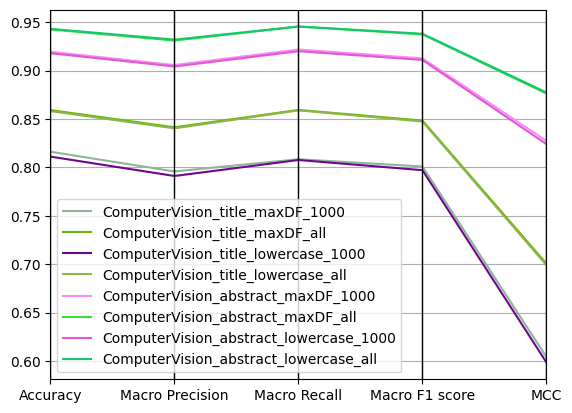

In [ ]:
parallel(models, test["ComputerVision"])

#### ComputationalLinguistics(Statistical)

In [ ]:
## Statistical Prediction Results of "ComputationalLinguistics"
models = [Stat_Lin_Title_MaxDF_1000, Stat_Lin_Title_MaxDF_all, Stat_Lin_Title_Low_1000, Stat_Lin_Title_Low_all, 
          Stat_Lin_Abs_MaxDF_1000, Stat_Lin_Abs_MaxDF_all, Stat_Lin_Abs_Low_1000, Stat_Lin_Abs_Low_all]
print("--------------------- ComputationalLinguistics ---------------------")
for model in models:
    print(f"--- {model.task}_{model.input}_{model.preprocessing}_{model.dataSize} ---")
    result(model.fit().predict(test_data=test)[0], test["ComputationalLinguistics"])
    print("\n")

--------------------- ComputationalLinguistics ---------------------
--- ComputationalLinguistics_title_maxDF_1000 ---
get_feature_names:  282
[[13904   794]
 [ 1564  1804]]
Accuracy: 0.8694785785453337
Macro Precision: 0.7966341597134754
Macro Recall: 0.740804249224853
Macro F1 score:0.7632964175500103
MCC:0.5345306955610634


--- ComputationalLinguistics_title_maxDF_all ---
get_feature_names:  269
[[14102   596]
 [ 1287  2081]]
Accuracy: 0.895771061662792
Macro Precision: 0.8468657771720716
Macro Recall: 0.7886621873029407
Macro F1 score:0.8129588626399488
MCC:0.6328571211230054


--- ComputationalLinguistics_title_lowercase_1000 ---
get_feature_names:  282
[[13840   858]
 [ 1533  1835]]
Accuracy: 0.8676519428761209
Macro Precision: 0.7908379617922336
Macro Recall: 0.7432292200305826
Macro F1 score:0.7629994098935331
MCC:0.5319409388344136


--- ComputationalLinguistics_title_lowercase_all ---
get_feature_names:  269
[[14108   590]
 [ 1301  2067]]
Accuracy: 0.8953282408944979
Macro P

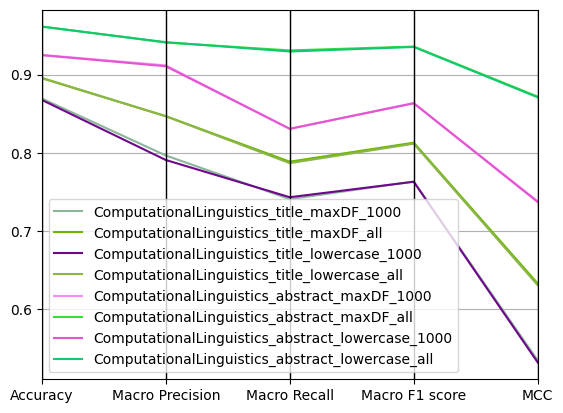

In [ ]:
parallel(models, test["ComputationalLinguistics"])

### Results of RNN models

**-------------------- All RNN models --------------------**

Combination of InformationTheory(Info)

> RNN_Info_Title_Stem_1000 \\
> RNN_Info_Title_Stem_all \\
> RNN_Info_Title_Low_1000 \\
> RNN_Info_Title_Low_all \\
> RNN_Info_Abs_Stem_1000 \\
> RNN_Info_Abs_Stem_all \\
> RNN_Info_Abs_Low_1000 \\
> RNN_Info_Abs_Low_all \\

Combination of ComputerVision(Vis)
> RNN_Vis_Title_Stem_1000 \\
> RNN_Vis_Title_Stem_all \\
> RNN_Vis_Title_Low_1000 \\
> RNN_Vis_Title_Low_all \\
> RNN_Vis_Abs_Stem_1000 \\
> RNN_Vis_Abs_Stem_all \\
> RNN_Vis_Abs_Low_1000 \\
> RNN_Vis_Abs_Low_all \\

Combination of ComputationalLinguistics(Lin)
> RNN_Lin_Title_Stem_1000 \\
> RNN_Lin_Title_Stem_all \\
> RNN_Lin_Title_Low_1000 \\
> RNN_Lin_Title_Low_all \\
> RNN_Lin_Abs_Stem_1000 \\
> RNN_Lin_Abs_Stem_all \\
> RNN_Lin_Abs_Low_1000 \\
> RNN_Lin_Abs_Low_all \\

#### InformationTheory(RNN)

In [ ]:
## RNN Prediction Results of "InformationTheory"
models = [RNN_Info_Title_Stem_1000, RNN_Info_Title_Stem_all, RNN_Info_Title_Low_1000, RNN_Info_Title_Low_all, 
          RNN_Info_Abs_Stem_1000, RNN_Info_Abs_Stem_all , RNN_Info_Abs_Low_1000, RNN_Info_Abs_Low_all]
print("--------------------- Training ---------------------")
for model in models:
    print(f"--- {model.task}_{model.input}_{model.preprocessing}_{model.dataSize} ---")
    y_predict, y_test = model.fit_predict(MAX_VOCAB_SIZE = 5400, N_EPOCHS=60)
    print("Done!")

print("--------------------- InformationTheory ---------------------")
for model in models:
    print(f"--- {model.task}_{model.input}_{model.preprocessing}_{model.dataSize} ---")
    result(model.y_predict, model.y_test)
    print("\n")

--------------------- Training ---------------------
--- InformationTheory_title_stemming_1000 ---
Unique tokens in TEXT vocabulary: 2207
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.629 | Train Acc: 72.40%
	 Val. Loss: 0.631 |  Val. Acc: 70.05%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.615 | Train Acc: 72.81%
	 Val. Loss: 0.624 |  Val. Acc: 70.05%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.596 | Train Acc: 74.27%
	 Val. Loss: 0.619 |  Val. Acc: 70.05%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.585 | Train Acc: 74.38%
	 Val. Loss: 0.617 |  Val. Acc: 70.05%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.571 | Train Acc: 74.48%
	 Val. Loss: 0.616 |  Val. Acc: 70.05%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.562 | Train Acc: 76.15%
	 Val. Loss: 0.617 |  Val. Acc: 70.05%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.562 | Train Acc: 74.48%
	 Val. Loss: 0.618 |  Val. Acc: 70.05%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.562 | Train Acc: 75.52%
	 Val. Loss: 0.619 |  Val. Acc: 70.05

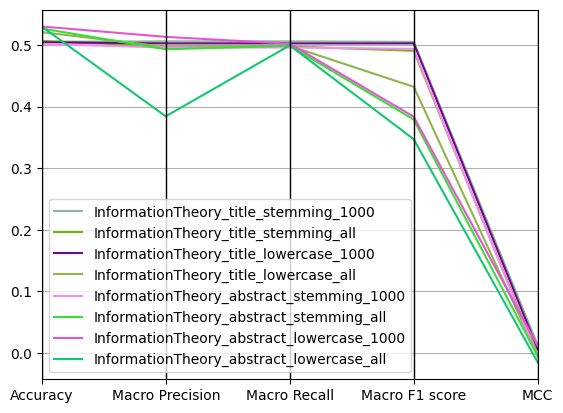

In [ ]:
parallel(models, test["InformationTheory"])

#### ComputerVision(RNN)

In [ ]:
## RNN Prediction Results of "ComputerVision"
models = [RNN_Vis_Title_Stem_1000, RNN_Vis_Title_Stem_all, RNN_Vis_Title_Low_1000, RNN_Vis_Title_Low_all, 
          RNN_Vis_Abs_Stem_1000, RNN_Vis_Abs_Stem_all , RNN_Vis_Abs_Low_1000, RNN_Vis_Abs_Low_all]
print("--------------------- Training ---------------------")
for model in models:
    print(f"--- {model.task}_{model.input}_{model.preprocessing}_{model.dataSize} ---")
    y_predict, y_test = model.fit_predict(MAX_VOCAB_SIZE = 5400, N_EPOCHS=60)
    print("Done!")

print("--------------------- ComputerVision ---------------------")
for model in models:
    print(f"--- {model.task}_{model.input}_{model.preprocessing}_{model.dataSize} ---")
    result(model.y_predict, model.y_test)
    print("\n")

--------------------- Training ---------------------
--- ComputerVision_title_stemming_1000 ---
Unique tokens in TEXT vocabulary: 2207
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.702 | Train Acc: 49.69%
	 Val. Loss: 0.707 |  Val. Acc: 47.05%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.702 | Train Acc: 46.77%
	 Val. Loss: 0.702 |  Val. Acc: 47.05%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.697 | Train Acc: 48.33%
	 Val. Loss: 0.700 |  Val. Acc: 47.05%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.697 | Train Acc: 50.21%
	 Val. Loss: 0.699 |  Val. Acc: 47.05%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.693 | Train Acc: 49.79%
	 Val. Loss: 0.698 |  Val. Acc: 47.05%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.694 | Train Acc: 47.92%
	 Val. Loss: 0.697 |  Val. Acc: 44.70%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.693 | Train Acc: 51.88%
	 Val. Loss: 0.697 |  Val. Acc: 44.70%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.697 | Train Acc: 43.44%
	 Val. Loss: 0.697 |  Val. Acc: 43.92%
E

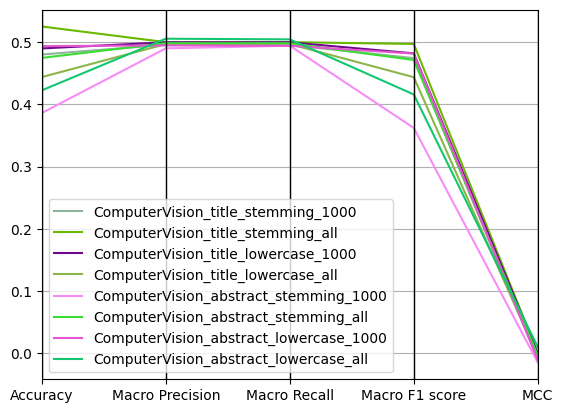

In [ ]:
parallel(models, test["ComputerVision"])

#### ComputationalLinguistics(RNN)

In [ ]:
## RNN Prediction Results of "ComputationalLinguistics"
models = [RNN_Lin_Title_Stem_1000, RNN_Lin_Title_Stem_all, RNN_Lin_Title_Low_1000, RNN_Lin_Title_Low_all, 
          RNN_Lin_Abs_Stem_1000, RNN_Lin_Abs_Stem_all , RNN_Lin_Abs_Low_1000, RNN_Lin_Abs_Low_all]
print("--------------------- Training ---------------------")
for model in models:
    print(f"--- {model.task}_{model.input}_{model.preprocessing}_{model.dataSize} ---")
    y_predict, y_test = model.fit_predict(MAX_VOCAB_SIZE = 5400, N_EPOCHS=60)
    print("Done!")

print("--------------------- ComputationalLinguistics ---------------------")
for model in models:
    print(f"--- {model.task}_{model.input}_{model.preprocessing}_{model.dataSize} ---")
    result(model.y_predict, model.y_test)
    print("\n")

--------------------- Training ---------------------
--- ComputationalLinguistics_title_stemming_1000 ---
Unique tokens in TEXT vocabulary: 2207
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.622 | Train Acc: 73.33%
	 Val. Loss: 0.573 |  Val. Acc: 82.12%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.593 | Train Acc: 75.00%
	 Val. Loss: 0.543 |  Val. Acc: 82.12%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.598 | Train Acc: 71.88%
	 Val. Loss: 0.528 |  Val. Acc: 82.12%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.585 | Train Acc: 73.02%
	 Val. Loss: 0.516 |  Val. Acc: 82.12%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.563 | Train Acc: 76.46%
	 Val. Loss: 0.504 |  Val. Acc: 82.12%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.570 | Train Acc: 74.79%
	 Val. Loss: 0.497 |  Val. Acc: 82.12%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.578 | Train Acc: 73.54%
	 Val. Loss: 0.493 |  Val. Acc: 82.12%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.570 | Train Acc: 74.58%
	 Val. Loss: 0.490 |  Val. Acc

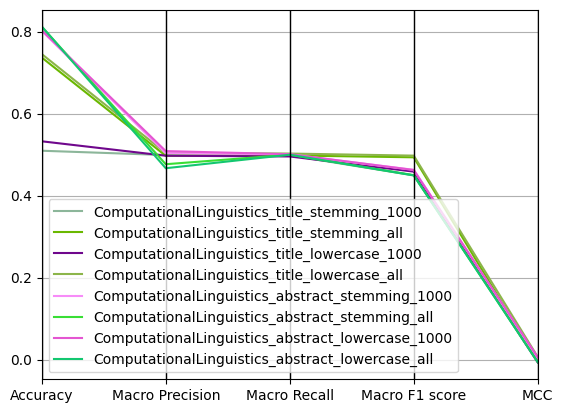

In [ ]:
parallel(models, test["ComputationalLinguistics"])

## Part 1D: Plots for Methods

Define a `Statistical_plot_curve` function for visualizing precision-recall curve. 


### Statistical precision-recall curve

In [ ]:
def Statistical_plot_curves(classifiers):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    plt.suptitle('Precision-Recall Curve')
    
    for classifier in classifiers:
        ## Calculate precision and recall for different probability thresholds
        precision, recall, thresholds = precision_recall_curve(classifier.y_test, classifier.y_predict_proba[:, 1])
        ## Plot 1: the precision-recall curve
        if classifier.preprocessing == "lowercase":
            ax1.plot(recall, precision, label=f"{classifier.task}_{classifier.input}_{classifier.preprocessing}_{classifier.dataSize}")
            ax1.legend()
        else:
            ax2.plot(recall, precision, label=f"{classifier.task}_{classifier.input}_{classifier.preprocessing}_{classifier.dataSize}")
            ax2.legend()
        ax1.set_xlabel('Recall')
        ax1.set_ylabel('Precision')
        ax1.set_title("Lowercase")
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title("Max_DF")
    plt.show()

#### InformationTheory(Statistical)

--------------------- InformationTheory ---------------------


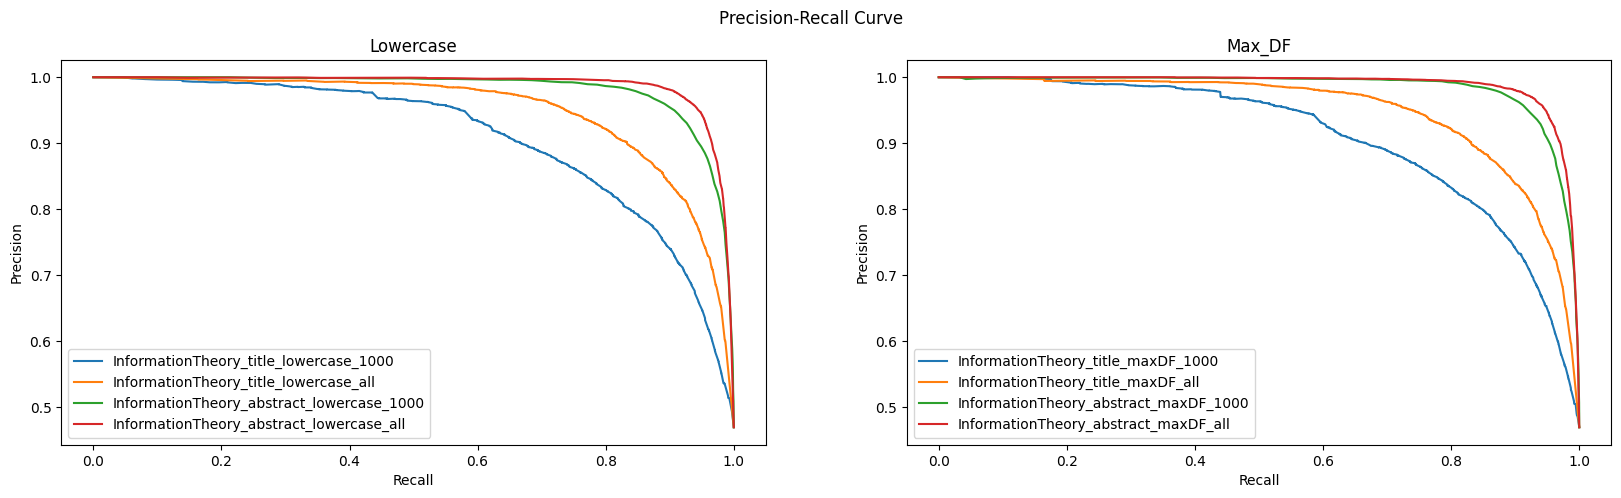

In [ ]:
## Statistical precision-recall of "InformationTheory"
models = [Stat_Info_Title_MaxDF_1000, Stat_Info_Title_MaxDF_all, Stat_Info_Title_Low_1000, Stat_Info_Title_Low_all , 
          Stat_Info_Abs_MaxDF_1000, Stat_Info_Abs_MaxDF_all, Stat_Info_Abs_Low_1000, Stat_Info_Abs_Low_all]
print("--------------------- InformationTheory ---------------------")
Statistical_plot_curves(models)

#### ComputerVision(Statistical)

--------------------- ComputerVision ---------------------


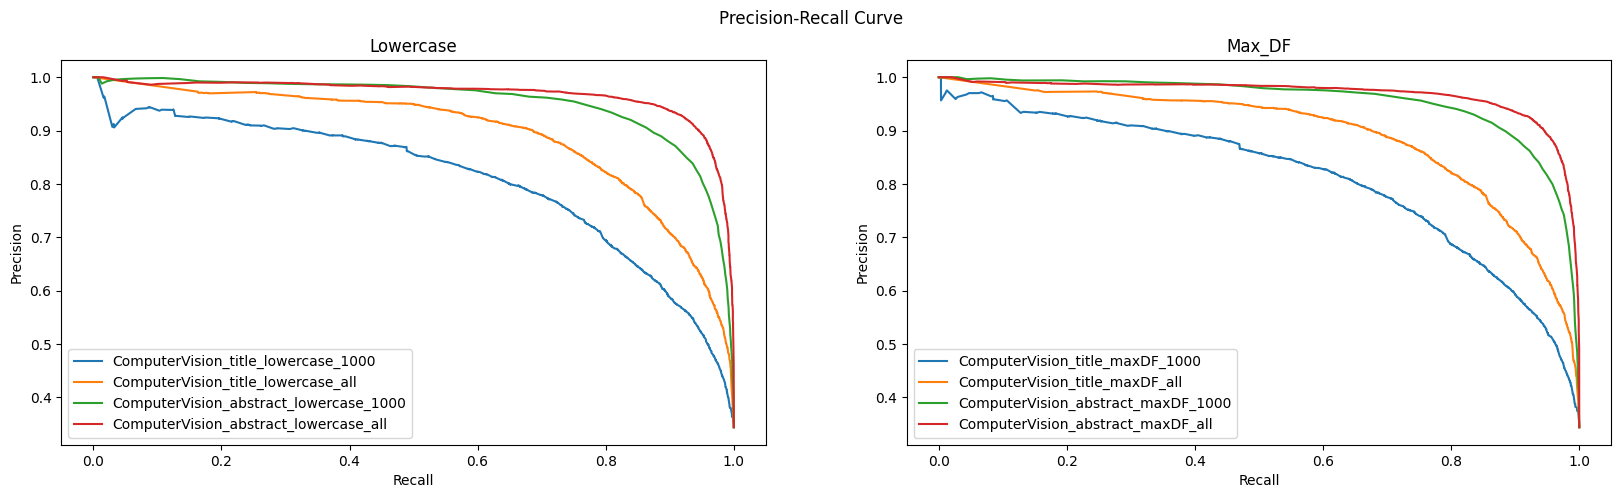

In [ ]:
## Statistical precision-recall of "ComputerVision"
models = [Stat_Vis_Title_MaxDF_1000, Stat_Vis_Title_MaxDF_all, Stat_Vis_Title_Low_1000, Stat_Vis_Title_Low_all, 
          Stat_Vis_Abs_MaxDF_1000, Stat_Vis_Abs_MaxDF_all, Stat_Vis_Abs_Low_1000, Stat_Vis_Abs_Low_all]
print("--------------------- ComputerVision ---------------------")
Statistical_plot_curves(models)

#### ComputationalLinguistics(Statistical)

--------------------- ComputationalLinguistics ---------------------


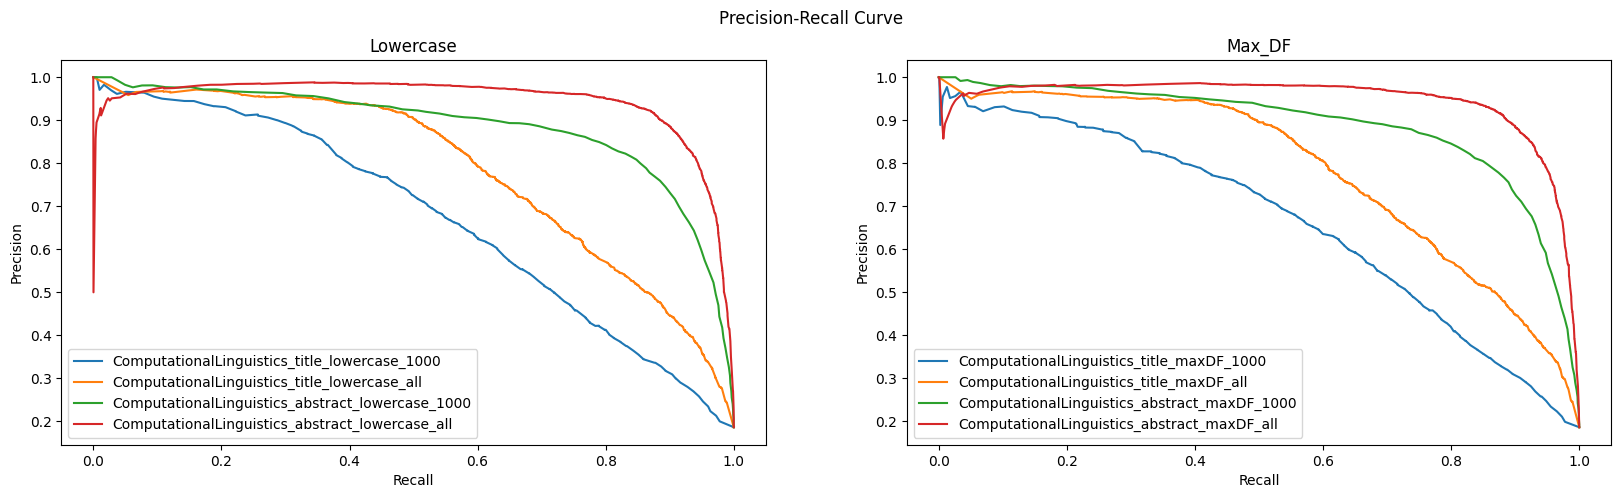

In [ ]:
## Statistical precision-recall of "ComputationalLinguistics"
models = [Stat_Lin_Title_MaxDF_1000, Stat_Lin_Title_MaxDF_all, Stat_Lin_Title_Low_1000, Stat_Lin_Title_Low_all, 
          Stat_Lin_Abs_MaxDF_1000, Stat_Lin_Abs_MaxDF_all, Stat_Lin_Abs_Low_1000, Stat_Lin_Abs_Low_all]
print("--------------------- ComputationalLinguistics ---------------------")
Statistical_plot_curves(models)

### RNN precision-recall curve, loss curve and accuracy curve

`RNN_plot_curve` takes a list of classifiers as input. The function plots two types of graphs - Precision-Recall curves and training accuracy and loss curves - for each classifier in the list.

For the Precision-Recall curves, the curves on two separate subplots based on whether the classifier's preprocessing parameter is "lowercase" or not.

For training accuracy and loss curves, I plotted the accuracy and loss records of each epoch for the training accuracy and loss curves. This helped me monitor the performance of the model and identify any signs of overfitting.

In [ ]:
def RNN_plot_curve(classifiers):

    ## Plot 1. Precision-recall curve
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    plt.suptitle('Precision-Recall Curve', fontsize=16)    
    for classifier in classifiers:
        ## Calculate precision and recall for different probability thresholds
        precision, recall, thresholds = precision_recall_curve(classifier.y_test, classifier.y_predict_proba)
        if classifier.preprocessing == "lowercase":
            ax1.plot(recall, precision, label=f"{classifier.task}_{classifier.input}_{classifier.preprocessing}_{classifier.dataSize}")
            ax1.legend()
        else:
            ax2.plot(recall, precision, label=f"{classifier.task}_{classifier.input}_{classifier.preprocessing}_{classifier.dataSize}")
            ax2.legend()
        ## Lowercse
        ax1.set_xlabel('Recall')
        ax1.set_ylabel('Precision')
        ax1.set_title("Lowercase")
        ## Max_DF
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.set_title("Max_DF")
    plt.show()

    ## Plot 2. Training accuracy and loss curve
    for classifier in classifiers:
        epoch_info = classifier.epoch_info
        fig = plt.figure(figsize=(15, 5))
        fig.suptitle(f"{classifier.task}_{classifier.input}_{classifier.preprocessing}_{classifier.dataSize}", fontsize=16) ## Use model name as title

        ## Loss
        ax2 = plt.subplot(121)
        loss_train = epoch_info['train_loss']
        loss_val = epoch_info['val_loss']
        epochs = range(len(loss_train))
        ax2.plot(epochs, loss_train, 'g', label='Training loss')
        ax2.plot(epochs, loss_val, 'b', label='validation loss')
        ax2.set_title('Training and Validation Loss')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
        ax2.legend()

        ## Accuracy
        ax3 = plt.subplot(122)
        acc_train = np.array(epoch_info['train_acc'])/100
        acc_val = np.array(epoch_info['val_acc'])/100
        epochs = range(len(acc_train))
        ax3.plot(epochs, acc_train, 'g', label='Training accuracy')
        ax3.plot(epochs, acc_val, 'b', label='validation accuracy')
        ax3.set_title('Training and Validation Accuracy')
        ax3.set_xlabel('Epochs')
        ax3.set_ylabel('Accuracy')
        ax3.legend()
        plt.show()


#### InformationTheory(RNN)

--------------------- InformationTheory ---------------------


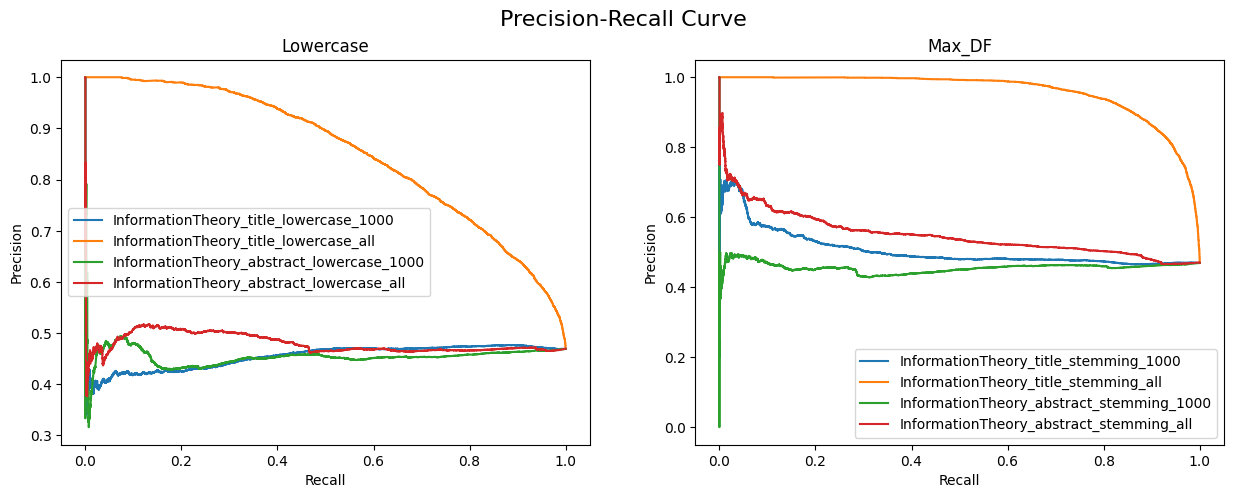

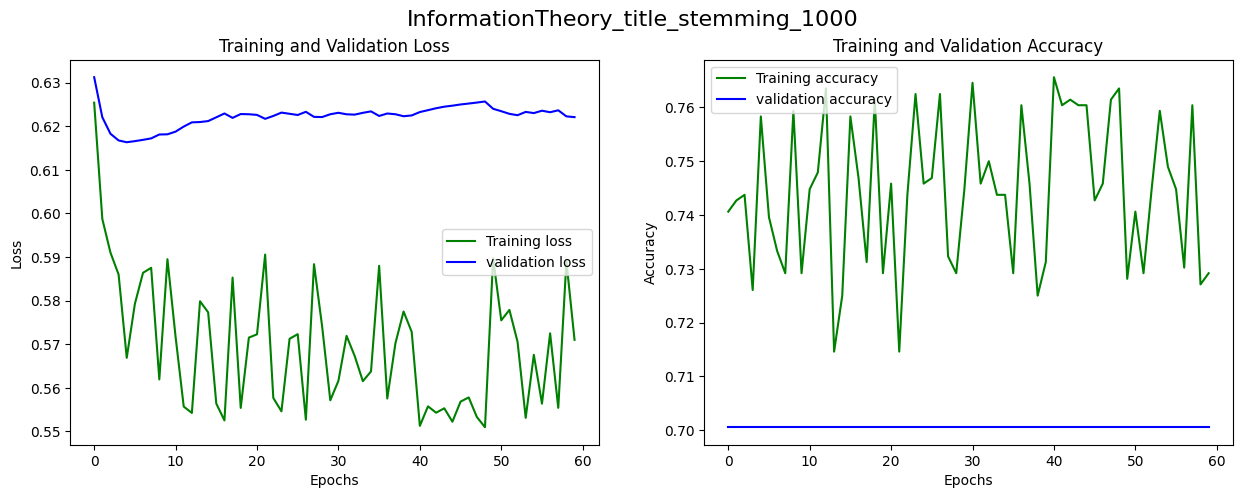

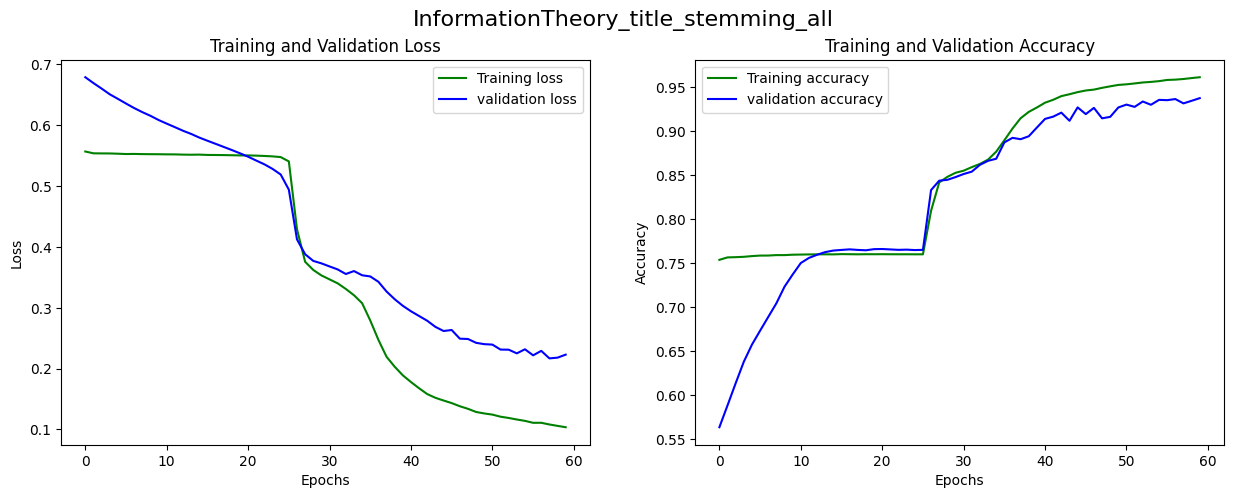

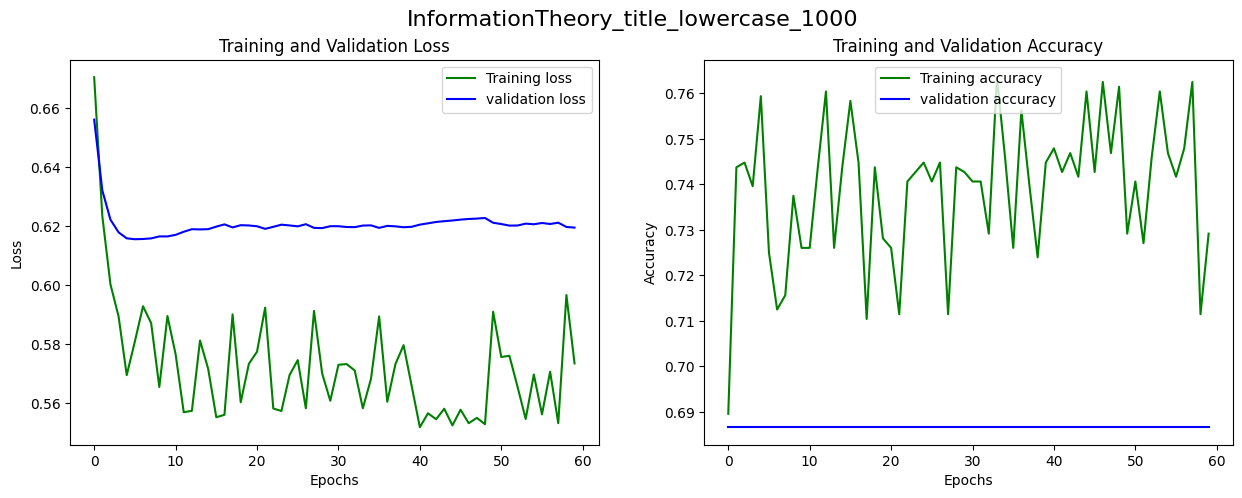

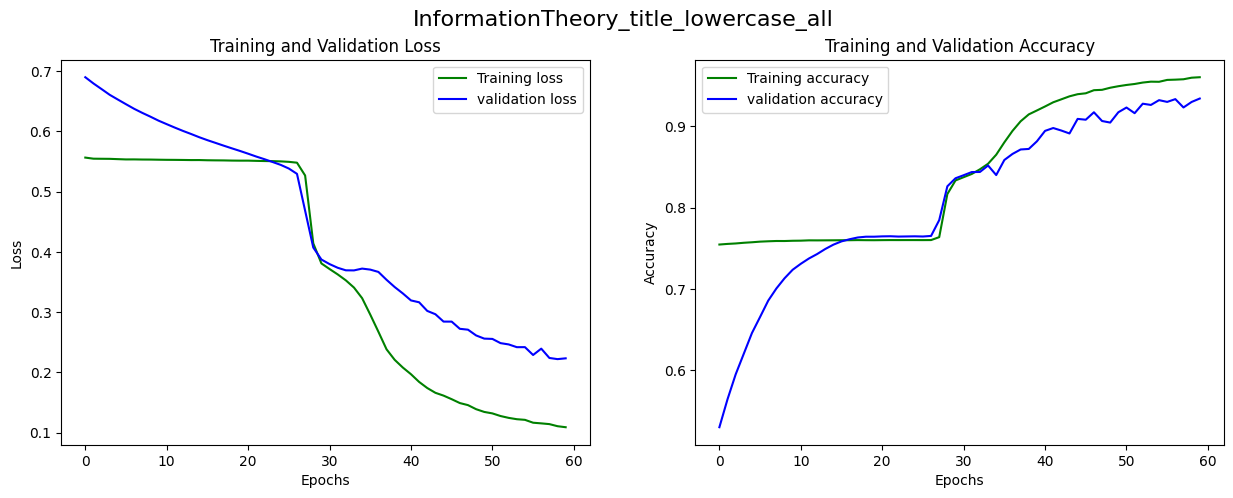

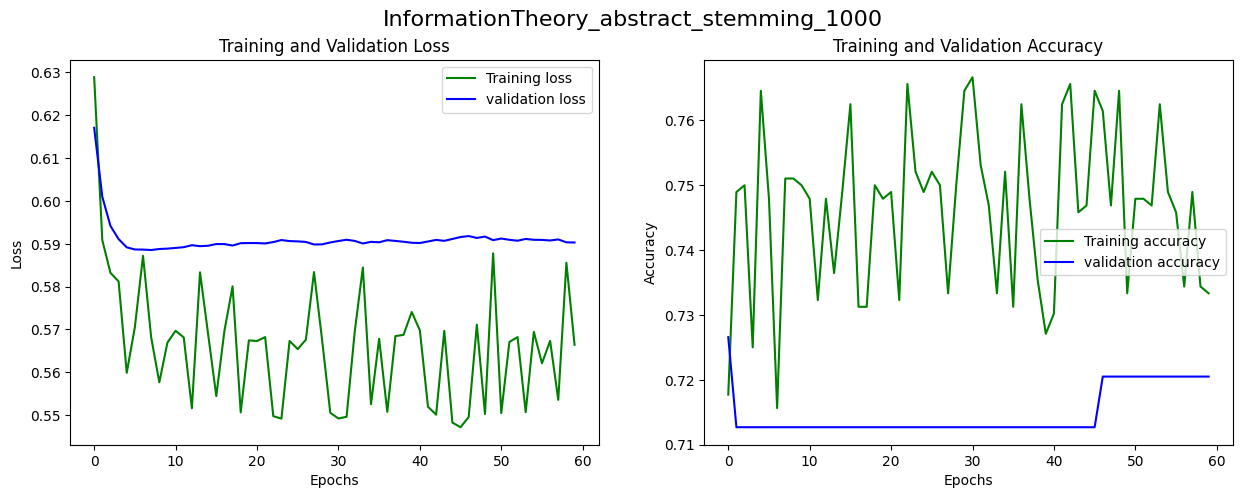

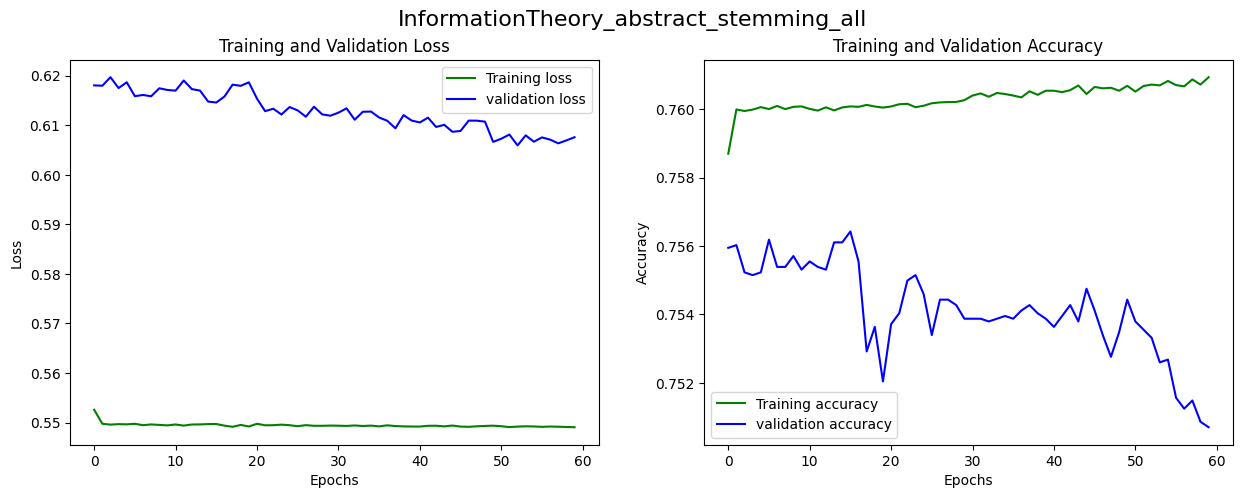

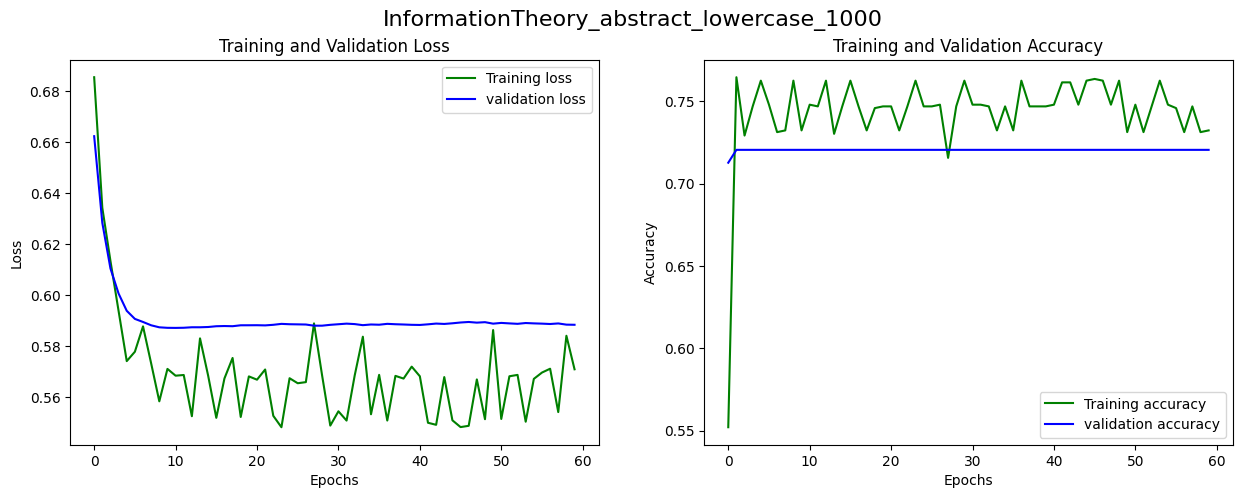

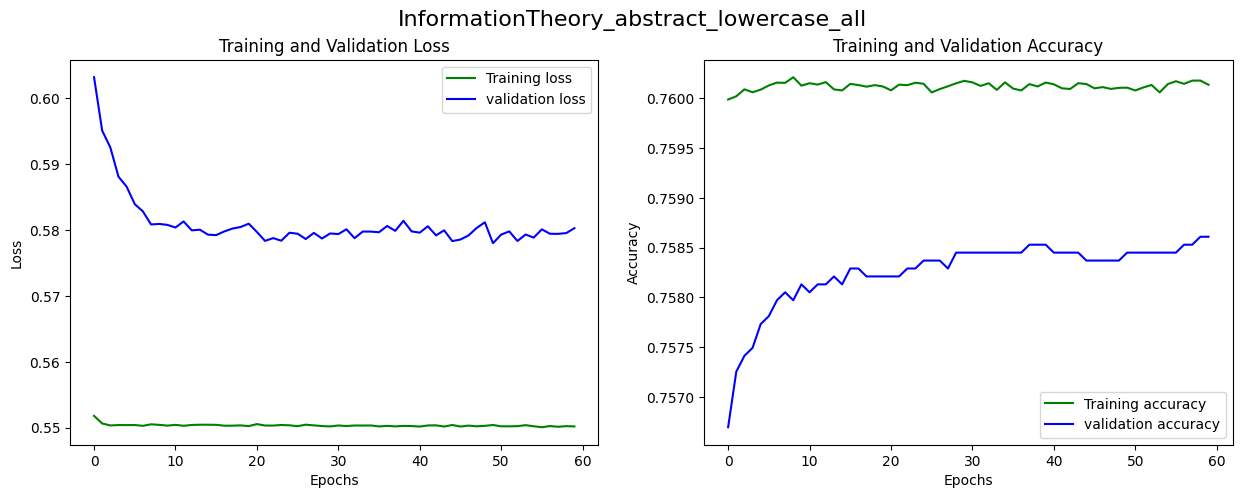

In [ ]:
## RNN curves of "InformationTheory"
models = [RNN_Info_Title_Stem_1000, RNN_Info_Title_Stem_all, RNN_Info_Title_Low_1000, RNN_Info_Title_Low_all, 
          RNN_Info_Abs_Stem_1000, RNN_Info_Abs_Stem_all , RNN_Info_Abs_Low_1000, RNN_Info_Abs_Low_all]
print("--------------------- InformationTheory ---------------------")
RNN_plot_curve(models)

#### ComputerVision(RNN)

--------------------- ComputerVision ---------------------


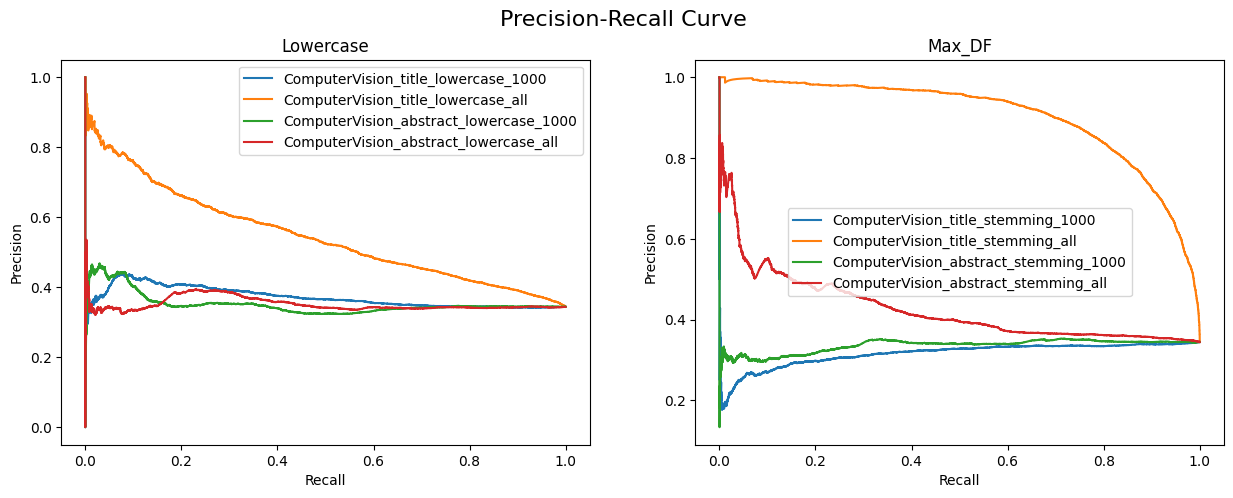

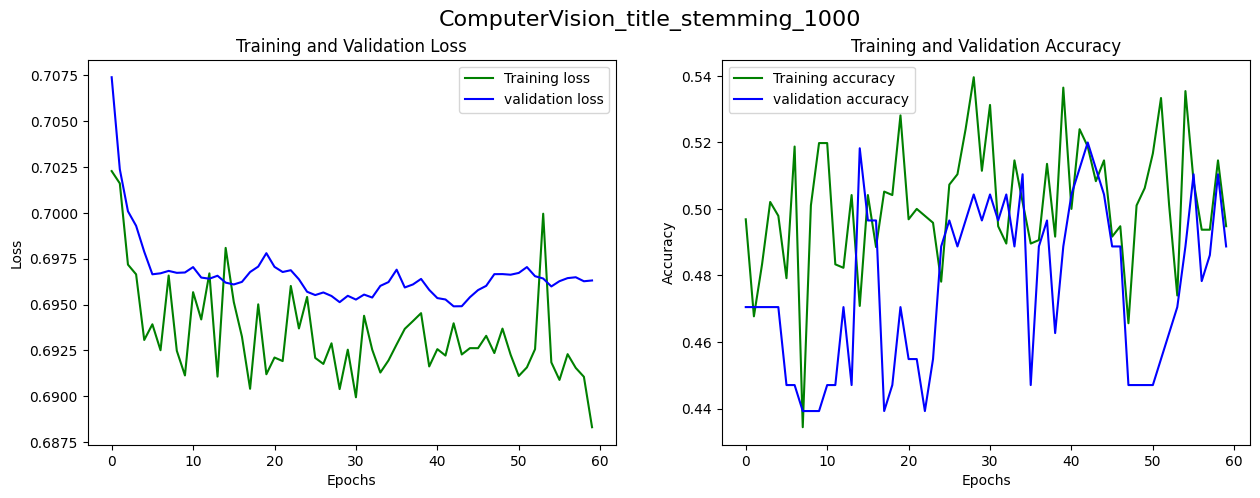

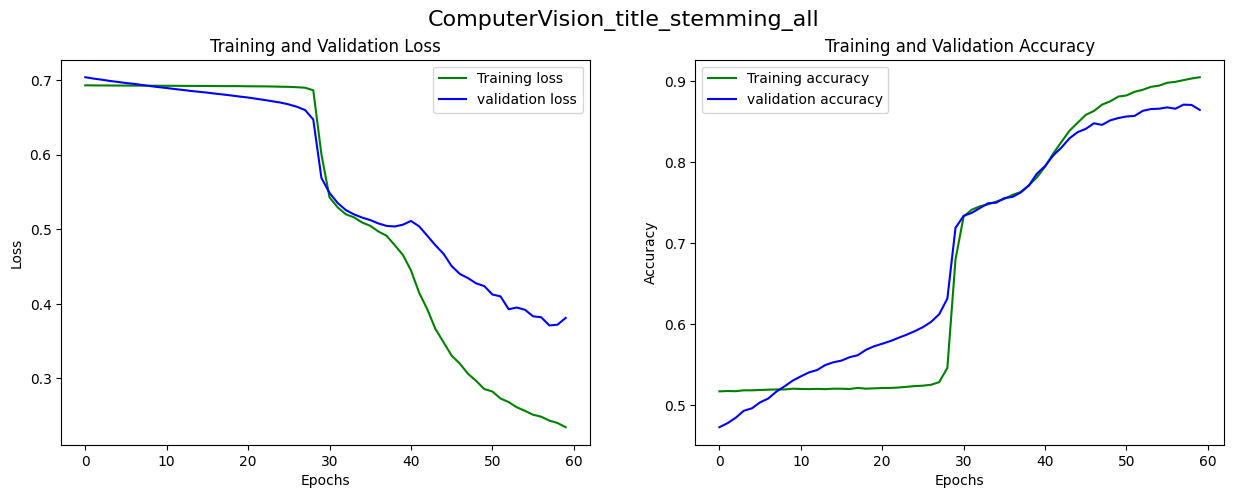

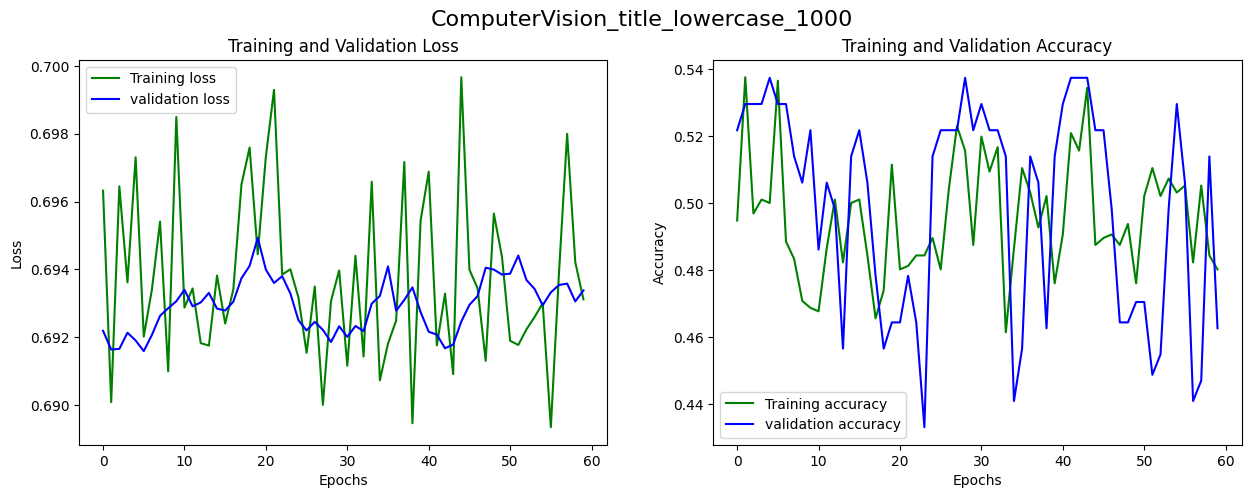

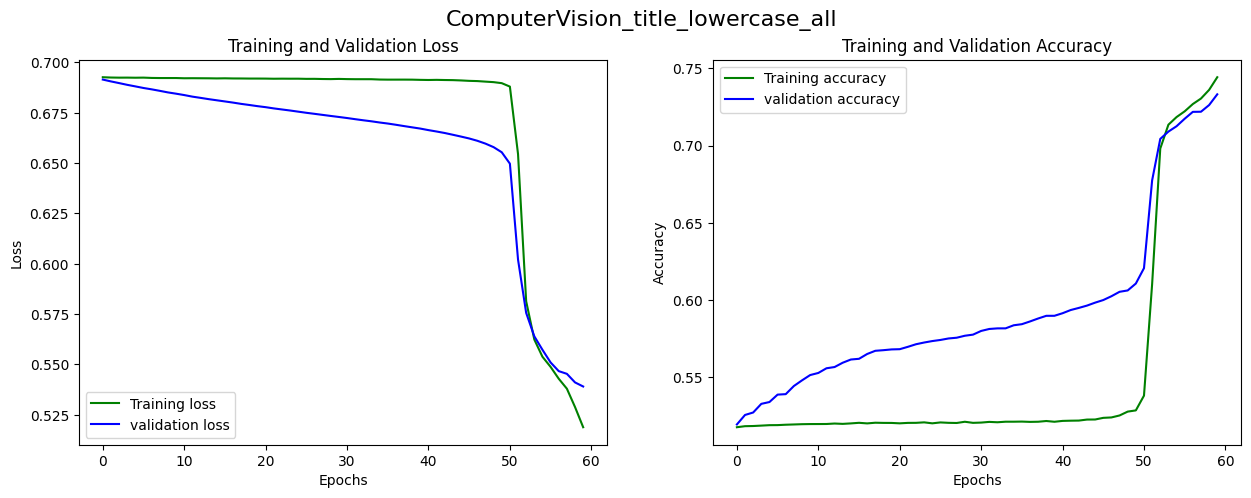

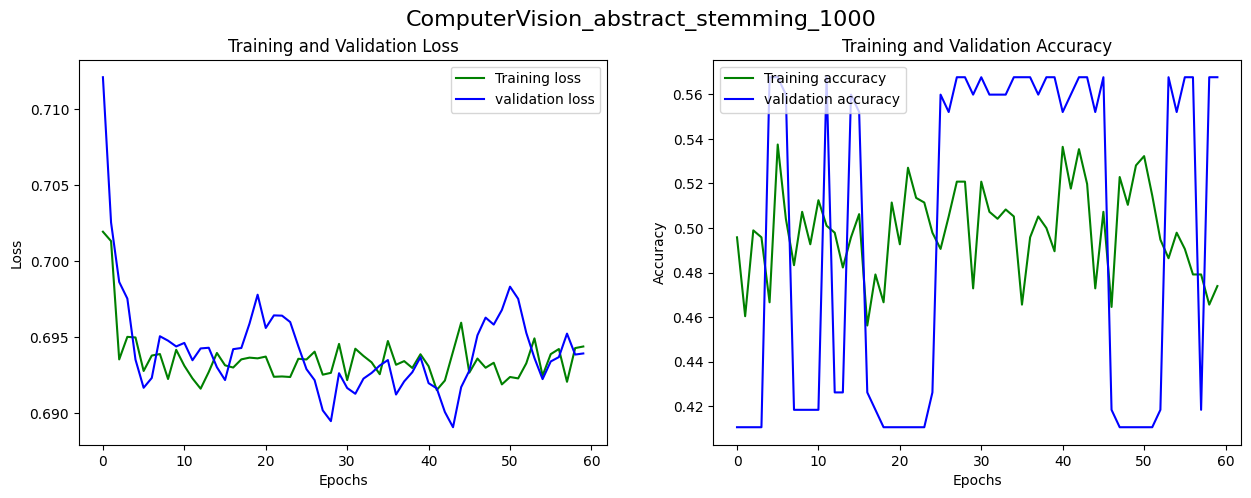

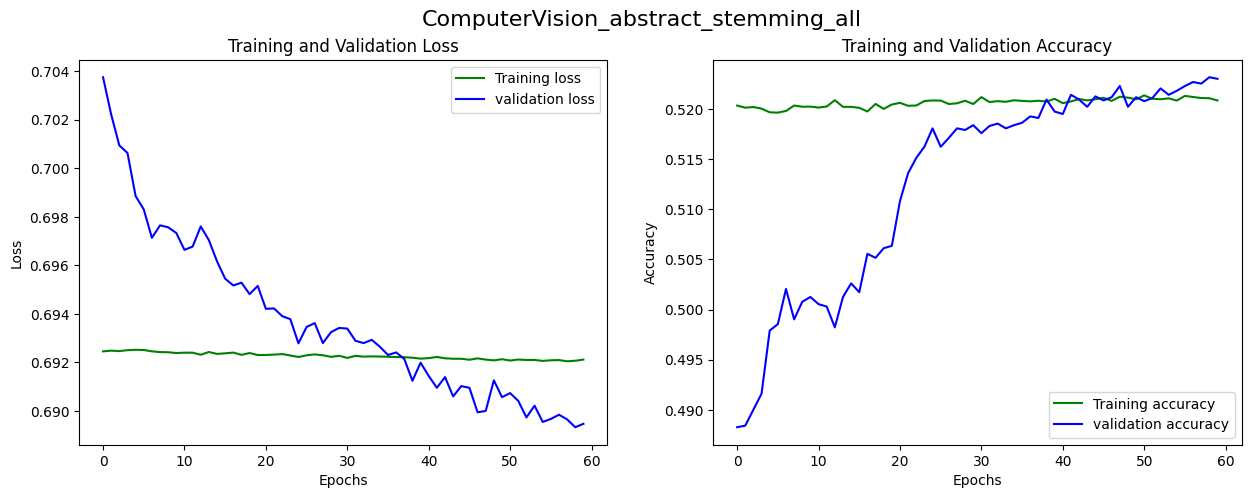

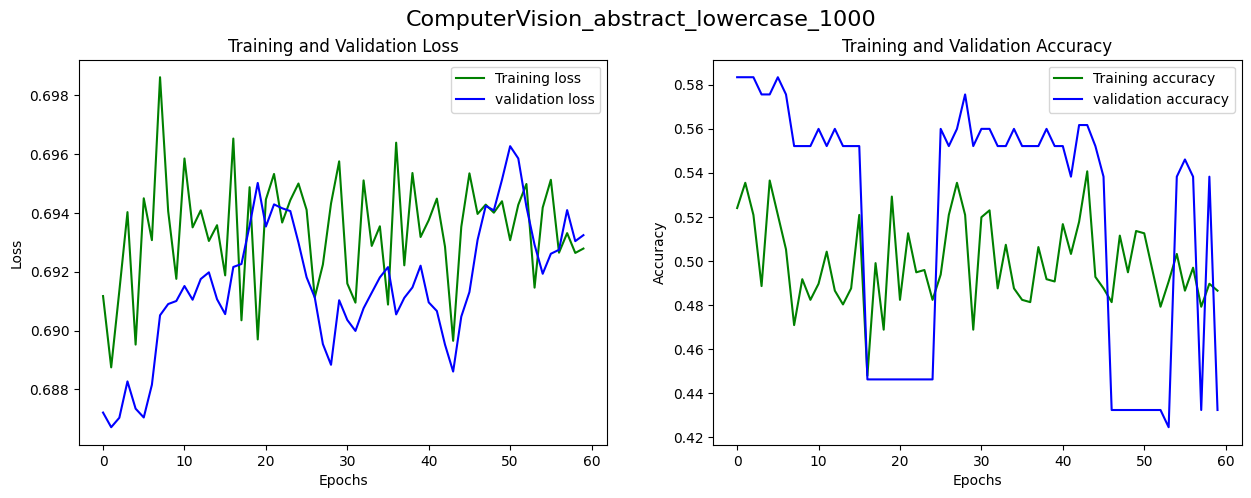

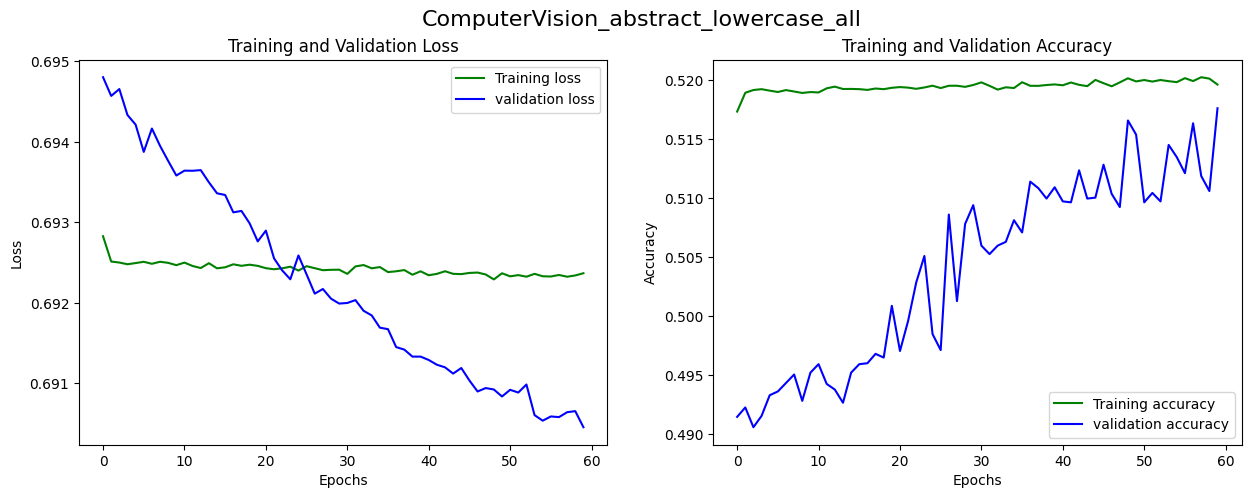

In [ ]:
## RNN curves of "ComputerVision"
models = [RNN_Vis_Title_Stem_1000, RNN_Vis_Title_Stem_all, RNN_Vis_Title_Low_1000, RNN_Vis_Title_Low_all, 
          RNN_Vis_Abs_Stem_1000, RNN_Vis_Abs_Stem_all , RNN_Vis_Abs_Low_1000, RNN_Vis_Abs_Low_all]
print("--------------------- ComputerVision ---------------------")
RNN_plot_curve(models)

#### ComputationalLinguistics(RNN)

--------------------- ComputationalLinguistics ---------------------


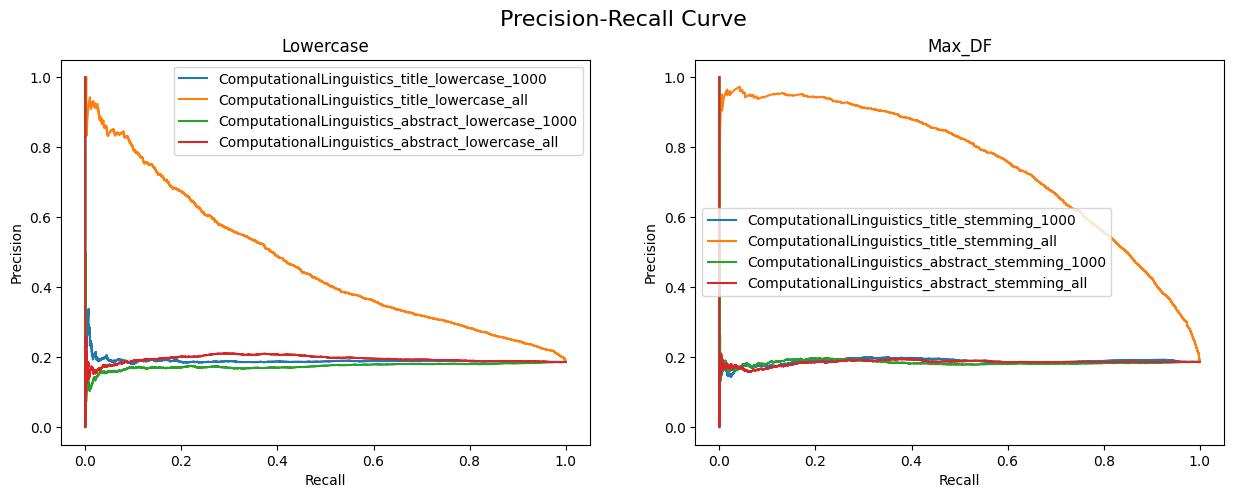

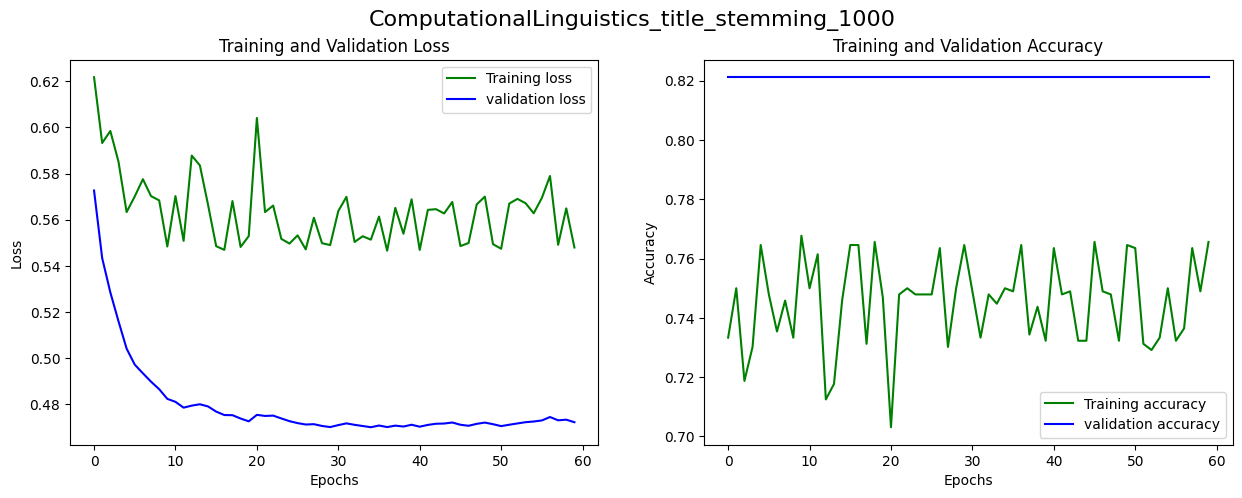

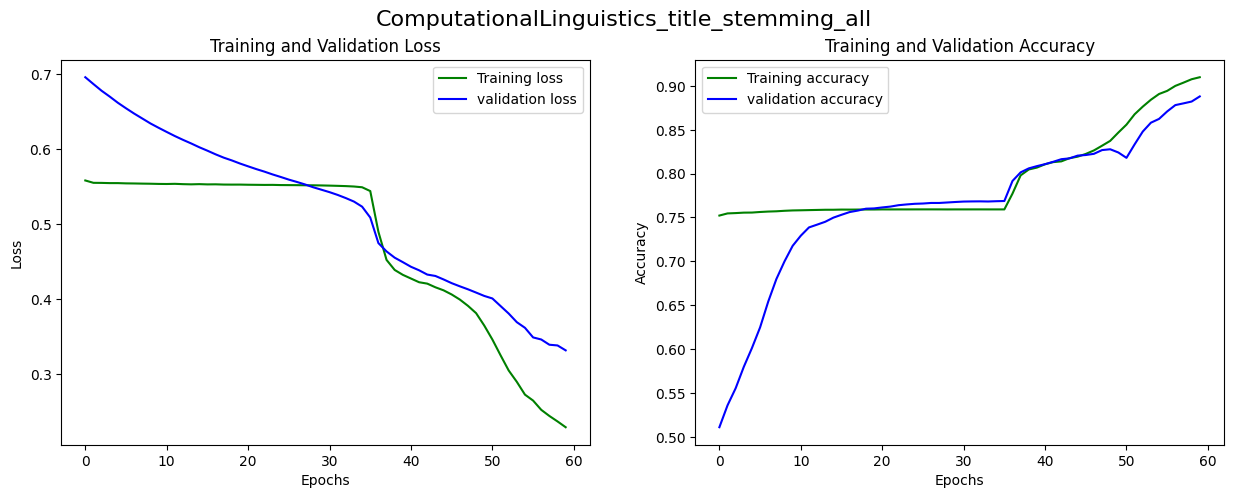

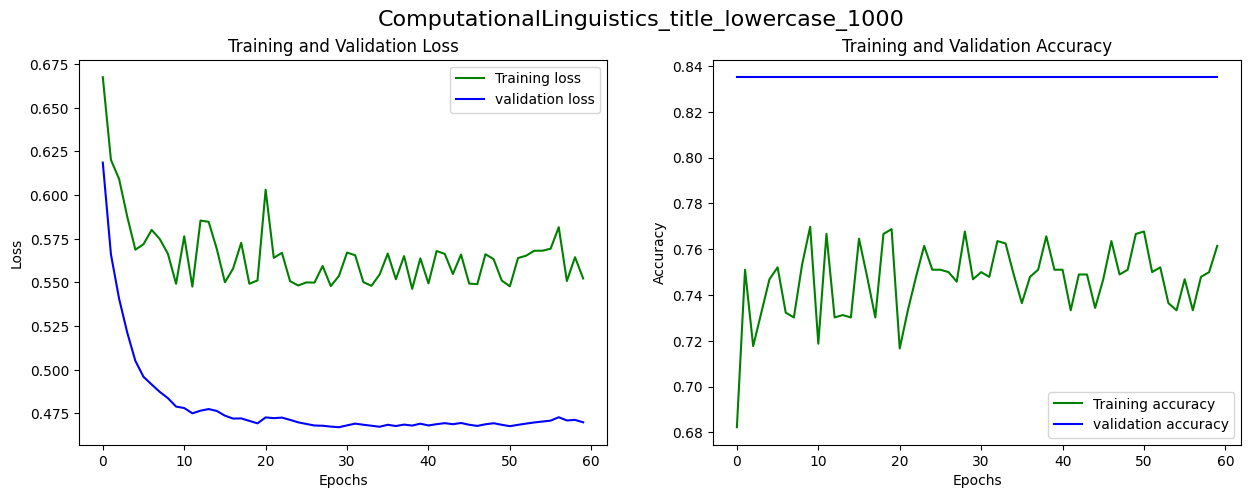

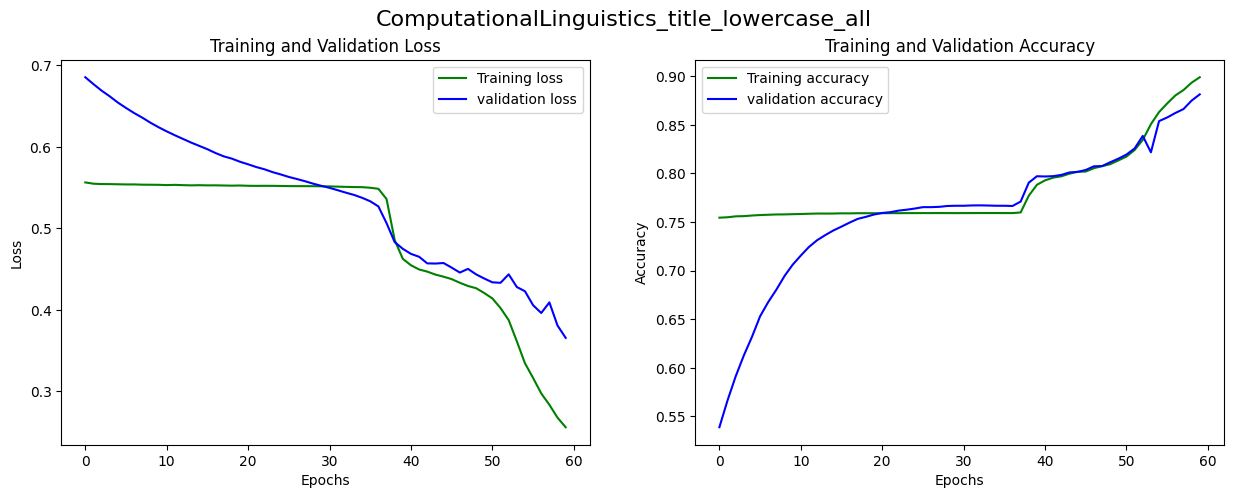

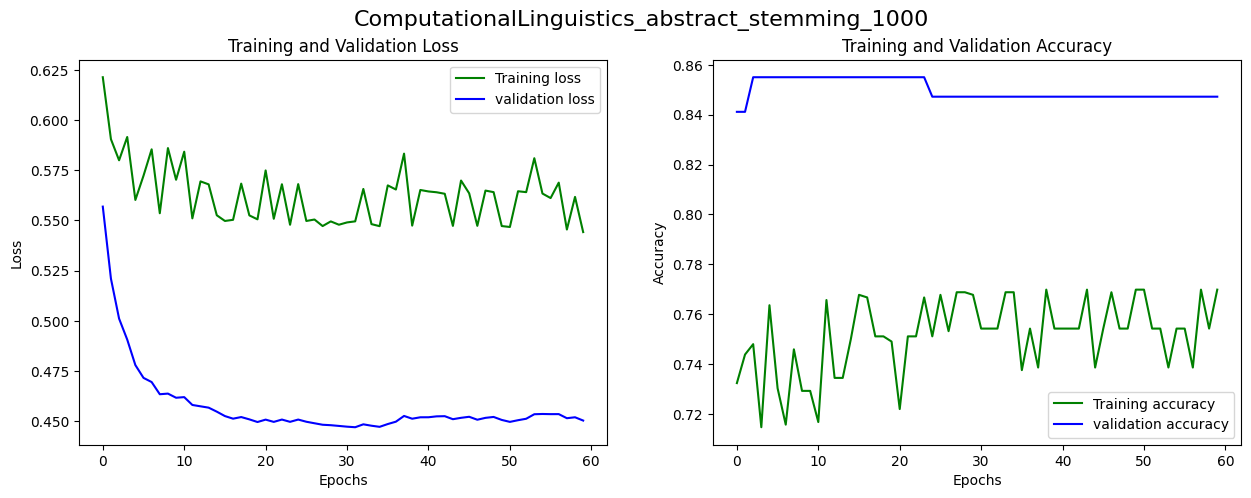

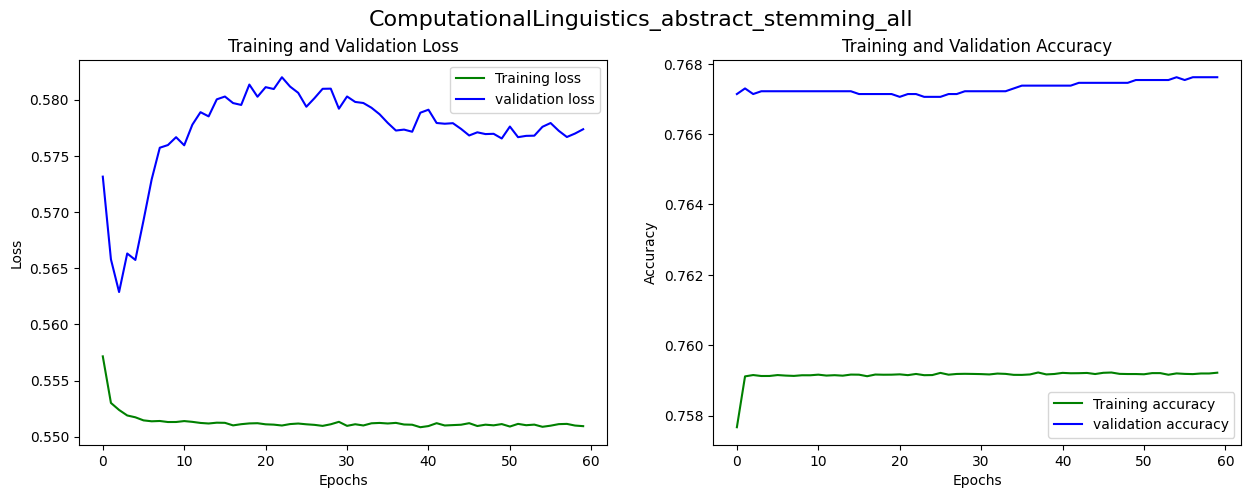

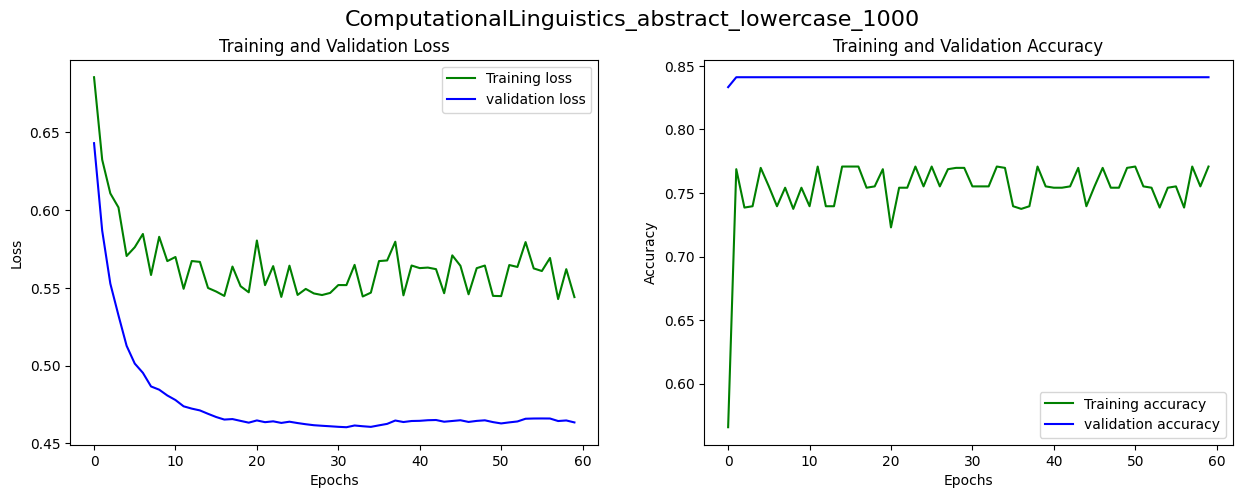

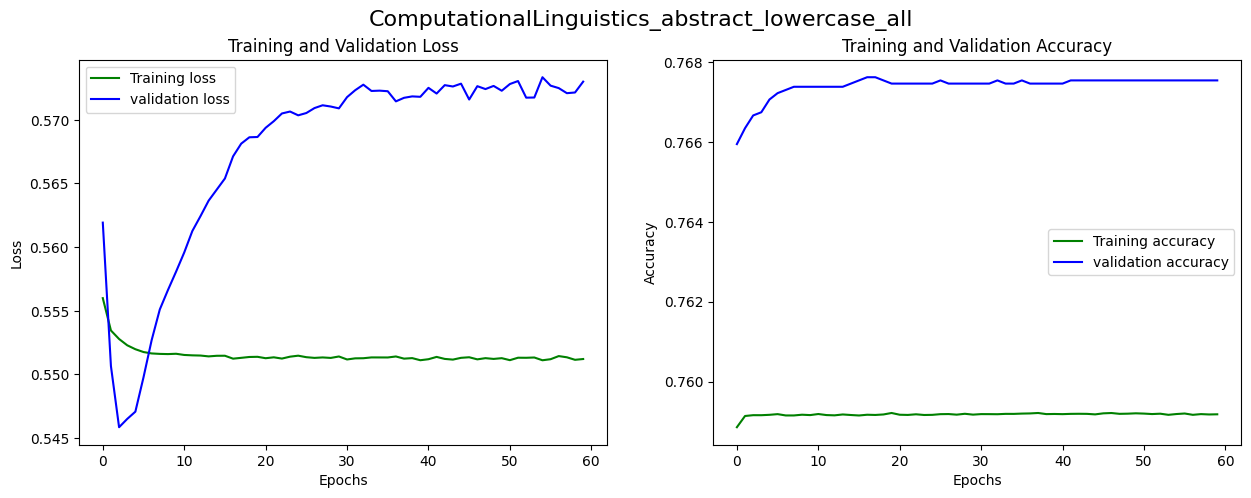

In [ ]:
## RNN curves of "ComputationalLinguistics"
models = [RNN_Lin_Title_Stem_1000, RNN_Lin_Title_Stem_all, RNN_Lin_Title_Low_1000, RNN_Lin_Title_Low_all, 
          RNN_Lin_Abs_Stem_1000, RNN_Lin_Abs_Stem_all , RNN_Lin_Abs_Low_1000, RNN_Lin_Abs_Low_all]
print("--------------------- ComputationalLinguistics ---------------------")
RNN_plot_curve(models)

# Part 2: Topic Modelling


Load data and packages.

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/FIT5212_Ass1/train.csv")
test = pd.read_csv("/content/drive/MyDrive/FIT5212_Ass1/test.csv")

In [ ]:
## if "NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968"
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"
!pip install pyLDAvis==2.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97736 sha256=901fab4c0adc4b504a36f8f2d06ecbf17f27a762fcb301942b3acb827a57a8b9
  Stored in directory: /root/.cache/pip/wheels/59/70/ee/99a0df99d8b4a7b87c79640ebee0927c0f6ccff046e9cc2471
Successfully built pyLDAvis


In [ ]:
from nltk.tokenize import RegexpTokenizer
import nltk
nltk.download('wordnet')
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis.gensim

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Data preparation. First 1000 and first 20000 data.

In [ ]:
raw_1000 = train.abstract.head(1000).tolist()
raw_20000 = train.abstract.head(20000).tolist()
trian_1000 = train.abstract.head(1000).tolist()
trian_1000_bigram = train.abstract.head(1000).tolist()
train_20000 = train.abstract.head(20000).tolist()
train_20000_bigram = train.abstract.head(20000).tolist()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Training and Visualization

The `analysis_prepare` function takes a list of documents as input and performs various text preprocessing steps to prepare the data for topic modeling using the Latent Dirichlet Allocation (LDA) algorithm. It first tokenizes each document using a regular expression pattern, converts all tokens to lowercase, removes tokens consisting entirely of numeric characters or one character words, and then lemmatizes the remaining tokens using the WordNetLemmatizer function. It also optionally creates bigrams from the tokenized documents. The function then creates a dictionary representation of the documents, filters out rare and common tokens, and creates a bag-of-words representation of the documents. Finally, the function trains an LDA model on the corpus and saves the model to a file. The function returns the trained LDA model, the corpus, and the dictionary for the visualization. The code at the end of the function calls the `analysis_prepare` function on different datasets with different bigram options and saves the resulting models, corpora, and dictionaries to separate variables.

In [ ]:
def analysis_prepare(data, bigram=True):
    # Split the documents into tokens.
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(data)):
        data[idx] = data[idx].lower()  # Convert to lowercase.
        data[idx] = tokenizer.tokenize(data[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    data = [[token for token in doc if not token.isnumeric()] for doc in data]

    # Remove words that are only one character.
    data = [[token for token in doc if len(token) > 1] for doc in data]

    ## Lemmatize the remaining tokens.
    lemmatizer = WordNetLemmatizer()
    data = [[lemmatizer.lemmatize(token) for token in doc] for doc in data]

    ## bigram 
    if bigram:
        bigram = Phrases(data, min_count=20) ## Create bigrams from the tokenized documents.
        for idx in range(len(data)):
            for token in bigram[data[idx]]:
                if '_' in token:
                    # Token is a bigram, add to document.
                    data[idx].append(token)



    ## Remove rare and common tokens.
    # Create a dictionary representation of the documents.
    dictionary = Dictionary(data)

    # Filter out words that occur less than 20 documents, or more than 50% of the documents.
    dictionary.filter_extremes(no_below=20, no_above=0.5)

    # Bag-of-words representation of the documents.
    corpus = [dictionary.doc2bow(doc) for doc in data]

    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))



    ###########################################################################################################################
    ################################################ Train LDA model.##########################################################
    ###########################################################################################################################
    # Set training parameters.
    NUM_TOPICS = 3
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make a index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token

    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha='auto',
        eta='auto',
        iterations=iterations,
        num_topics=NUM_TOPICS,
        passes=passes,
        eval_every=eval_every
    )
    outputfile = f'model{NUM_TOPICS}.gensim'
    print("Saving model in " + outputfile)
    print("")
    model.save(outputfile)

    return model, corpus, dictionary

## Call the analysis_prepare function on different datasets with different bigram options.(2 by 2)
model_1000_T, corpus_1000_T, dictionary_1000_T = analysis_prepare(trian_1000, True)
model_1000_F, corpus_1000_F, dictionary_1000_F = analysis_prepare(trian_1000_bigram, False)
model_20000_T, corpus_20000_T, dictionary_20000_T = analysis_prepare(train_20000, True)
model_20000_F, corpus_20000_F, dictionary_20000_F = analysis_prepare(train_20000_bigram, False)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of unique tokens: 991
Number of documents: 1000
Saving model in model3.gensim

Number of unique tokens: 918
Number of documents: 1000


Saving model in model3.gensim

Number of unique tokens: 7150
Number of documents: 20000


Saving model in model3.gensim

Number of unique tokens: 5477
Number of documents: 20000


Saving model in model3.gensim



The code generates a visualization of the topics learned by an LDA model using the pyLDAvis library. The prepare function is used to prepare the data for the visualization by taking the LDA model, the bag-of-words corpus, and the dictionary. The sort_topics parameter is set to False so that the topics are not sorted in any particular order. The resulting visualization can help to better understand the topics learned by the model and their relationships to each other. The display function is then used to display the visualization in the Jupyter notebook or console.

In [ ]:
## bigram, 1000
lda_display = pyLDAvis.gensim.prepare(model_1000_T, corpus_1000_T, dictionary_1000_T, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## no bigram, 1000
lda_display = pyLDAvis.gensim.prepare(model_1000_F, corpus_1000_F, dictionary_1000_F, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## bigram, 20000
lda_display = pyLDAvis.gensim.prepare(model_20000_T, corpus_20000_T, dictionary_20000_T, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## no bigram, 20000
lda_display = pyLDAvis.gensim.prepare(model_20000_F, corpus_20000_F, dictionary_20000_F, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


As a quick summary, the four topic distributions appear quite similar, with three distinct clusters that do not overlap. However, the plot reveals that the two clusters on the left side of the axis are closer to each other than to the cluster on the right side, indicating a higher degree of relatedness between the former two clusters.

### Things to experiment with


#### Find the most representative document for each topic

The function `get_document_topics` takes a pre-trained topic model (ldamodel), a corpus of documents (corpus), and a list of raw text documents (texts) as inputs. It then identifies the dominant topic for each document in the corpus and **calculates the percentage contribution of that topic to the document**. The function also extracts the keywords associated with the dominant topic and appends this information to a pandas dataframe. Finally, the function adds the original text of each document to the dataframe and returns it as output. The purpose of this function is to provide a convenient way to analyze the topics that are present in a corpus of text documents.

In [ ]:
def get_document_topics(ldamodel=model_1000_T, corpus=corpus_1000_T, texts=raw_1000):
   # Init output
    document_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                document_topics_df = document_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    document_topics_df = pd.concat([document_topics_df, contents], axis=1)

    document_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Original_Text']

    return document_topics_df

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The function `most_representative_document` is used to find the most representative document for each topic in a given corpus. It first uses the `get_document_topics()` function to obtain a dataframe that lists the dominant topic, its percentage contribution, its keywords, and the original text for each document in the corpus. Then, it groups the documents by their dominant topics, sorts them by their percentage contribution in descending order, and selects the top document for each topic. Finally, it returns a dataframe that shows the topic number, its percentage contribution, its keywords, and the text of the most representative document for each topic.

In [ ]:
def most_representative_document(ldamodel=model_1000_T, corpus=corpus_1000_T, texts=raw_1000):
    doc_topic_df = get_document_topics(ldamodel=model_1000_T, corpus=corpus_1000_T, texts=raw_1000)
    # Group top 5 sentences under each topic
    doc_topics_sorted_df = pd.DataFrame()

    doc_topic_df_grpd = doc_topic_df.groupby('Dominant_Topic')

    for i, grp in doc_topic_df_grpd:
        doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                                grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                                axis=0)

    doc_topics_sorted_df.reset_index(drop=True, inplace=True)
    doc_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
    return doc_topics_sorted_df.head(10)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
document_topics_df_1000_T = get_document_topics(ldamodel=model_1000_T, corpus=corpus_1000_T, texts=raw_1000)
most_representative_document(ldamodel=model_1000_T, corpus=corpus_1000_T, texts=raw_1000)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic_Num  Topic_Perc_Contrib  \
0          0              0.9991   
1          1              0.9992   
2          2              0.9992   

                                            Keywords  \
0  image, method, network, feature, model, from, ...   
1  code, channel, algorithm, it, be, can, problem...   
2  model, our, from, image, method, task, learnin...   

                                                Text  
0    3D urban reconstruction of buildings from re...  
1    We consider a D2D wireless network where $n$...  
2    The dominating NLP paradigm of training a st...

In [ ]:
document_topics_df_1000_F = get_document_topics(ldamodel=model_1000_F, corpus=corpus_1000_F, texts=raw_1000)
most_representative_document(ldamodel=model_1000_F, corpus=corpus_1000_F, texts=raw_1000)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic_Num  Topic_Perc_Contrib  \
0          0              0.9991   
1          1              0.9992   
2          2              0.9992   

                                            Keywords  \
0  image, method, network, feature, model, from, ...   
1  code, channel, algorithm, it, be, can, problem...   
2  model, our, from, image, method, task, learnin...   

                                                Text  
0    3D urban reconstruction of buildings from re...  
1    We consider a D2D wireless network where $n$...  
2    The dominating NLP paradigm of training a st...

In [ ]:
document_topics_df_20000_T = get_document_topics(ldamodel=model_20000_T, corpus=corpus_20000_T, texts=raw_20000)
most_representative_document(ldamodel=model_20000_T, corpus=corpus_20000_T, texts=raw_20000)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic_Num  Topic_Perc_Contrib  \
0          0              0.9991   
1          1              0.9992   
2          2              0.9992   

                                            Keywords  \
0  image, method, network, feature, model, from, ...   
1  code, channel, algorithm, it, be, can, problem...   
2  model, our, from, image, method, task, learnin...   

                                                Text  
0    3D urban reconstruction of buildings from re...  
1    We consider a D2D wireless network where $n$...  
2    The dominating NLP paradigm of training a st...

In [ ]:
document_topics_df_20000_F = get_document_topics(ldamodel=model_20000_F, corpus=corpus_20000_F, texts=raw_20000)
most_representative_document(ldamodel=model_20000_F, corpus=corpus_20000_F, texts=raw_20000)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic_Num  Topic_Perc_Contrib  \
0          0              0.9991   
1          1              0.9992   
2          2              0.9992   

                                            Keywords  \
0  image, method, network, feature, model, from, ...   
1  code, channel, algorithm, it, be, can, problem...   
2  model, our, from, image, method, task, learnin...   

                                                Text  
0    3D urban reconstruction of buildings from re...  
1    We consider a D2D wireless network where $n$...  
2    The dominating NLP paradigm of training a st...

#### Find the top-k most representative document for each topic

In [ ]:
def find_top_k_doc(doc_topic_df=document_topics_df_1000_T, k=2):

  doc_topics_sorted_df = pd.DataFrame()

  doc_topic_df_grpd = doc_topic_df.groupby('Dominant_Topic')

  for i, grp in doc_topic_df_grpd:
      doc_topics_sorted_df = pd.concat([doc_topics_sorted_df, 
                                              grp.sort_values(['Perc_Contribution'], ascending=[0]).head(k)], 
                                              axis=0)

  doc_topics_sorted_df.reset_index(drop=True, inplace=True)
  doc_topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
  return doc_topics_sorted_df


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
top_k_df_1000_T = find_top_k_doc(document_topics_df_1000_T)
top_k_df_1000_T

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic_Num  Topic_Perc_Contrib  \
0          0              0.9991   
1          0              0.9991   
2          1              0.9992   
3          1              0.9991   
4          2              0.9992   
5          2              0.9992   

                                            Keywords  \
0  image, method, network, feature, model, from, ...   
1  image, method, network, feature, model, from, ...   
2  code, channel, algorithm, it, be, can, problem...   
3  code, channel, algorithm, it, be, can, problem...   
4  model, our, from, image, method, task, learnin...   
5  model, our, from, image, method, task, learnin...   

                                                Text  
0    3D urban reconstruction of buildings from re...  
1    Over the past few years Generative Adversari...  
2    We consider a D2D wireless network where $n$...  
3    It is well known that an (nk) code can be us...  
4    The dominating NLP paradigm of training a st...  
5    We propose an end-to-end recurrent encoder-d...

In [ ]:
top_k_df_1000_F = find_top_k_doc(document_topics_df_1000_F)
top_k_df_1000_F

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic_Num  Topic_Perc_Contrib  \
0          0              0.9989   
1          0              0.9989   
2          1              0.9991   
3          1              0.9991   
4          2              0.9988   
5          2              0.9988   

                                            Keywords  \
0  code, channel, it, algorithm, be, can, problem...   
1  code, channel, it, algorithm, be, can, problem...   
2  model, our, image, network, method, from, task...   
3  model, our, image, network, method, from, task...   
4  image, method, our, object, data, network, fro...   
5  image, method, our, object, data, network, fro...   

                                                Text  
0    We consider a D2D wireless network where $n$...  
1    Nonparametric two sample testing is a decisi...  
2    Multilingual Neural Machine Translation (MNM...  
3    Machine Translation is one of the major olde...  
4    Moving object segmentation is a crucial task...  
5    Depth prediction is one of the fundamental p...

In [ ]:
top_k_df_20000_T = find_top_k_doc(document_topics_df_20000_T)
top_k_df_20000_T

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic_Num  Topic_Perc_Contrib  \
0          0              0.9992   
1          0              0.9992   
2          1              0.9992   
3          1              0.9992   
4          2              0.9991   
5          2              0.9991   

                                            Keywords  \
0  image, method, network, model, feature, based,...   
1  image, method, network, model, feature, based,...   
2  model, task, language, data, learning, it, whi...   
3  model, task, language, data, learning, it, whi...   
4  channel, code, it, problem, be, which, algorit...   
5  channel, code, it, problem, be, which, algorit...   

                                                Text  
0    High angular resolution is advantageous for ...  
1    There have been a fairly of research interes...  
2    Although pre-trained language models such as...  
3    Active learning has been shown to be an effe...  
4    In this paper we study the information theor...  
5    Since radio signals carry both energy and in...

In [ ]:
top_k_df_20000_F = find_top_k_doc(document_topics_df_20000_F)
top_k_df_20000_F

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic_Num  Topic_Perc_Contrib  \
0          0              0.9991   
1          0              0.9990   
2          1              0.9991   
3          1              0.9991   
4          2              0.9993   
5          2              0.9993   

                                            Keywords  \
0  channel, code, it, problem, be, which, algorit...   
1  channel, code, it, problem, be, which, algorit...   
2  model, task, language, data, text, it, based, ...   
3  model, task, language, data, text, it, based, ...   
4  image, method, network, model, feature, learni...   
5  image, method, network, model, feature, learni...   

                                                Text  
0    Since radio signals carry both energy and in...  
1    Suppose Alice wishes to send messages to Bob...  
2    We study the problem of deep recall model in...  
3    Neural text matching models have been widely...  
4    Person re-identification (re-ID) has recentl...  
5    Deep Learning (DL) and specifically CNN mode...

Have a look at the top 2 most representive documents for Topic 0.

In [ ]:
from pprint import pprint
T = 0
for index, row in top_k_df_20000_F[top_k_df_20000_F['Topic_Num']==T].iterrows():
  print("Doc Contribution is %d" , row["Keywords"])
  pprint(row["Text"] + "\n-------------------------------------------------")

Doc Contribution is %d channel, code, it, problem, be, which, algorithm, can, rate, system
('  Since radio signals carry both energy and information at the same time a\n'
 'unified study on simultaneous wireless information and power transfer '
 '(SWIPT)\n'
 'has recently drawn a significant attention for achieving wireless powered\n'
 'communication networks. In this paper we study a multiple-input '
 'single-output\n'
 '(MISO) multicast SWIPT network with one multi-antenna transmitter sending\n'
 'common information to multiple single-antenna receivers simultaneously '
 'along\n'
 'with opportunistic wireless energy harvesting at each receiver. From the\n'
 'practical consideration we assume that the channel state information (CSI) '
 'is\n'
 'only known at each respective receiver but is unavailable at the '
 'transmitter.\n'
 'We propose a novel receiver mode switching scheme for SWIPT based on a new\n'
 'application of the conventional random beamforming technique at the\n'
 'mult

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Have a look at keywords of each topic.

In [ ]:
for T in range(3):
    print("Keywords of Topic", T)
    print(list(top_k_df_20000_F[top_k_df_20000_F['Topic_Num']==T].Keywords.head(1))[0])

Keywords of Topic 0
channel, code, it, problem, be, which, algorithm, can, rate, system
Keywords of Topic 1
model, task, language, data, text, it, based, word, which, can
Keywords of Topic 2
image, method, network, model, feature, learning, based, data, which, can


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


To sum up, considering exclusive keywords($\lambda$=0) and the paragraph, we can name the topic as follows:  

- Wireless Communication Topic: bound, coding, interface, transmission, wireless
- NLP Topic: language, word, text, sentence, speech, dialogue
- Vision Topic: image, segmentation, 2D, 3D, camera, scene, color

System topic can be compared to Information Theory, NLP topic can be compared to Computational Linguistics, and Vision topic can be compared to Computer Vision, all of which are very similar to the original data.

### Cluster Accuracy.

We know clustering is not equal to classification. However, in this three topics case, we can observe that for each row, the sum of three columns, "InformationTheory", "ComputationalLinguistics", and "ComputerVision", is always equal to 1. Therefore, we can make use of them to assume these three task labels in the original train data are correct answers for the clusters.

First, for checking, we calculate the number of rows where the sum of the values in the 'InformationTheory', 'ComputationalLinguistics', and 'ComputerVision' columns does not equal 1. The output of 0 indicates that the sum of every row is 1.

In [ ]:
## check whether the sum of three columns for each row is all equal to 1.
(train[['InformationTheory', 'ComputationalLinguistics', 'ComputerVision']].sum(axis=1) != 1).sum()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0

Take 5 rows for example, we can see cluster0 in `20000 non bigram` model represents ComputerVision(row0, row2), cluster1 represents InformationTheory(row3, row4), and cluster2 represents ComputationalLinguistics(row1).

In [ ]:
document_topics_df_20000_F.Dominant_Topic[:5], train[['InformationTheory', 'ComputationalLinguistics', 'ComputerVision']][:5]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0    0
 1    2
 2    0
 3    1
 4    1
 Name: Dominant_Topic, dtype: int64,
    InformationTheory  ComputationalLinguistics  ComputerVision
 0                  0                         0               1
 1                  0                         1               0
 2                  0                         0               1
 3                  1                         0               0
 4                  1                         0               0)

After knowing the relationship between them, I try to transform three columns in the train data to align with the form of Dominant_Topic cluster(3 columns -> 1 column).

In [ ]:
def transfer_column(row, document_topics_df):
    if row.InformationTheory == 1:
        return document_topics_df.Dominant_Topic[3]
    elif row.ComputationalLinguistics == 1:
        return document_topics_df.Dominant_Topic[1]
    elif row.ComputerVision == 1:
        return document_topics_df.Dominant_Topic[0]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Finally, we can easily calculate the accuracy between `Dominant_Topic` and `transfered_column` to determine the percentage of our "predict" cluster that matches the original data labels (clusters).

In [ ]:
def cluster_accuracy(document_topics_df=document_topics_df_1000_T):
    transfered_column = train[['InformationTheory', 'ComputationalLinguistics', 'ComputerVision']].apply(lambda row: transfer_column(row, document_topics_df), axis = 1)

    ## Calculate accuracy
    same_count = 0
    for i in range(len(document_topics_df.Dominant_Topic)):
        if document_topics_df.Dominant_Topic[i] == transfered_column[i]:
            same_count += 1
    acc = same_count/len(document_topics_df.Dominant_Topic)
    return acc


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(f"Accuracy of n=1000 bigram model:{cluster_accuracy(document_topics_df=document_topics_df_1000_T)}")
print(f"Accuracy of n=1000 non bigram model:{cluster_accuracy(document_topics_df=document_topics_df_1000_F)}")
print(f"Accuracy of n=20000 bigram model:{cluster_accuracy(document_topics_df=document_topics_df_20000_T)}")
print(f"Accuracy of n=20000 non bigram model:{cluster_accuracy(document_topics_df=document_topics_df_20000_F)}")

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Accuracy of n=1000 bigram model:0.845
Accuracy of n=1000 non bigram model:0.864
Accuracy of n=20000 bigram model:0.888
Accuracy of n=20000 non bigram model:0.90695
